# Machine Learning 2
## Regression project
 
Mateusz Tomczak (432561)

## Introduction

In this project we will use machine learning model to predict a continous variable.

Models that will be used:

 - Regression Trees

 - XGBoost

 - Neural Network

# Data description


#### Dataset

Dataset contains the information about the public bicycles rented per hour in the Seoul Bike Sharing System as well as weather, season and time data as well as holiday information.

The columns from original dataset [Seoul Bike Sharing Demand](https://doi.org/10.24432/C5F62R) (2020) UCI Machine Learning Repository, are extended by 9 new features:

`feat01`, `feat02`, `feat03`, `feat04`, `feat05`, `feat06`, `feat07`, `feat08`, `feat10`

As well as an `id` column

#### Original data columns:

**Features**

- `Date` - [datetime] Date in format 'day/month/year'

- `Functioning day` - [binary] 'No' (Non Functional Hours), 'Yes' (Functional hours)

- `Hour` - [int] Hour of the day

- `Temperature` - [float] (C)

- `Humidity` - [int] (%)

- `Windspeed` - [float] (m/s)

- `Visibility` - [int] (10m) Visibility/10 in meters

- `Dew point temperature` - [float] (C)

- `Solar Radiation` - [float] (Mj/m^2)

- `Rainfall` - [int] (mm)

- `Snowfall` - [int] (cm)

- `Seasons` - [categorical] 'Winter', 'Spring', 'Summer', 'Autumn'

- `Holiday` - [binary] 'Holiday' or 'No holiday'



**Target**

- `Rented bike count` - [int] Count of bikes rented at each hour

#### Problem 

The goal is to predict the number of rented bikes per hour based on the provided features with highest possible accuracy 


In our analysis we will be using the following evaluation metrics:

$\text{MSE}\qquad\text{RMSE}\qquad R^2\qquad\text{MAE}$

### Import relevant libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.feature_selection import mutual_info_regression
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers
from xgboost import plot_tree as plot_tree_xgb
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2, root_mean_squared_error as RMSE, mean_absolute_error as MAE

### Helper functions

In [2]:
def summarize_variable(col, df, cat=False, target = "Rented Bike Count"):
    """Function used to present given feature

    Args:
        col (str): column that will be summarized
        df (pd.DataFrame): dataframe containing col
        cat (bool, optional): If given column is categorical. Defaults to False.
        target (str, optional): Target column name. Defaults to "Rented Bike Count".
    """
    x = df[col]
    unique_values = x.unique().tolist()
    print(col)
    if not cat:
        print(f"Min value:\t{min(unique_values)}\nMedian value:\t{x.median()}\nMean value:\t{x.mean()}\nMax value:\t{max(unique_values)}\nStd:\t\t{x.std()}")
    else:
        print("Unique values:")
        print(f"{unique_values}") if len(unique_values) < 50 else print(f"{unique_values[:50]}...")
        print(f"Number of unique values: {len(unique_values)}")
    print(f"\n{x.isna().sum()} missing values")
    fig, ax =plt.subplots(1,3)
    fig.set_figheight(7)
    fig.set_figwidth(15)
    sns.histplot(data=x, kde=False, ax=ax[0], bins=100)
    sns.boxplot(data=x, ax=ax[1])
    sns.scatterplot(x=x, y=df[target])
    plt.plot()

In [3]:
def get_performance_metrics(y_true, y_pred):
    """Returns MSE, RMSE, R2 and MAE performance metrics for given y_true i y_pred

    Args:
        y_true: True values of y
        y_pred: Predicted values of y

    Returns:
        dict: Dictionary of scores with keys 'MSE', 'RMSE', 'R2' and 'MAE'
    """
    return {
        "MSE": round(float(MSE(y_true, y_pred)),2),
        "RMSE": round(float(RMSE(y_true, y_pred)),2),
        "R2": round(float(R2(y_true, y_pred)),2),
        "MAE": round(float(MAE(y_true, y_pred)),2),
    }

#### Load the dataset

In [4]:
raw_data = pd.read_csv("data/r4.csv", parse_dates=["Date"], date_format='%d/%m/%Y')

## Data inspection

In [5]:
raw_data.sample(20)

id       Date  Dew point temperature    feat01    feat02    feat03  \
780      781 2018-02-02                  -12.4  0.412051  0.783392  0.457898   
3011    3012 2018-09-27                    5.4  0.633651  0.560181  0.437658   
6601    6602 2018-11-08                    9.0  0.600508  0.347357  0.080853   
1892    1893 2018-01-20                   -8.3  0.938051  0.750716  0.874232   
4338    4339 2017-12-30                   -4.0  0.218549  0.418332  0.676581   
6200    6201 2017-12-15                  -13.4  0.626853  0.561178  0.873954   
1254    1255 2017-12-13                  -18.2  0.159882  0.017323  0.834107   
1950    1951 2018-06-11                   11.1  0.848259  0.806062  0.096641   
2296    2297 2018-05-04                    2.2  0.775731  0.905531  0.474311   
11045  11046 2018-06-04                   10.5  0.612845  0.598923  0.320750   
10957  10958 2018-04-16                   -2.9  0.617031  0.356991  0.401155   
1506    1507 2018-04-24                    0.5  0.845920  0.744491  0.406349   
1980    1981 2018-08-01                   24.8  0.105980  0.992539  0.423966   
5819    5820 2018-05-14                   11.9  0.849210  0.003243  0.251395   
10805  10806 2018-03-17                   -5.1  0.156601  0.119923  0.835719   
10586  10587 2018-08-25                   18.3  0.422867  0.196882  0.725653   
3202    3203 2018-08-07                   22.3  0.866013  0.800775  0.832975   
9488    9489 2018-10-14                    3.9  0.415833  0.535523  0.641017   
1459    1460 2018-02-26                   -9.5  0.374013  0.603689  0.994325   
5741    5742 2018-03-31                    2.1  0.990544  0.641183  0.209701   

         feat04    feat05    feat06    feat07  ...  Hour  Humidity Rainfall  \
780    0.666475  0.799679  0.462646  0.450947  ...     2        59      0.0   
3011   0.122254  0.678303  0.076694  0.397341  ...    16        31      0.0   
6601   0.133745  0.043368  0.666643  0.372540  ...     6        90      1.5   
1892   0.172230  0.355907  0.513731  0.426982  ...    22        48      0.0   
4338   0.050804  0.325808  0.761760  0.361673  ...     5        81      0.0   
6200   0.700542  0.189076  0.325677  0.509516  ...     1        57      0.0   
1254   0.656852  0.650485  0.556699  0.253081  ...     1        52      0.0   
1950   0.605290  0.434576  0.134564  0.653363  ...     3        61      0.0   
2296   0.405861  0.101258  0.041283  0.345082  ...    21        47      0.0   
11045  0.612457  0.234683  0.407020  0.348769  ...    10        40      0.0   
10957  0.297846  0.048081  0.986151  0.556783  ...    20        35      0.0   
1506   0.643993  0.306795  0.380047  0.274298  ...    21        47      0.0   
1980   0.347407  0.157672  0.137777  0.553862  ...    22        64      0.0   
5819   0.900134  0.240675  0.630221  0.548676  ...    18        48      0.0   
10805  0.924502  0.863752  0.537122  0.472779  ...    11        39      0.0   
10586  0.970785  0.171618  0.840604  0.473311  ...    21        71      0.0   
3202   0.399519  0.542600  0.028197  0.571378  ...    12        57      0.0   
9488   0.509776  0.186306  0.801140  0.641701  ...     4        76      0.0   
1459   0.728939  0.757624  0.341541  0.701250  ...    22        40      0.0   
5741   0.340829  0.844471  0.674630  0.549661  ...    19        41      0.0   

      Rented Bike Count  Seasons  Snowfall  Solar Radiation  Temperature  \
780                 102   Winter       0.0             0.00         -5.7   
3011               1636   Autumn       0.0             1.37         23.6   
6601                136   Autumn       0.0             0.00         10.6   
1892                232   Winter       0.0             0.00          1.5   
4338                 52   Winter       0.0             0.00         -1.2   
6200                241   Winter       0.0             0.00         -6.3   
1254                183   Winter       0.0             0.00        -10.2   
1950                232   Summer       0.0             0.00  

In [6]:
raw_data.describe()

id                           Date  Dew point temperature  \
count  11680.000000                          11680           11680.000000   
mean    5840.500000  2018-05-01 14:00:19.726027520               0.752046   
min        1.000000            2017-12-01 00:00:00             -30.600000   
25%     2920.750000            2018-01-30 00:00:00             -10.025000   
50%     5840.500000            2018-04-01 00:00:00               0.700000   
75%     8760.250000            2018-08-01 00:00:00              11.525000   
max    11680.000000            2018-11-30 00:00:00              27.200000   
std     3371.869907                            NaN              13.496679   

             feat01        feat02        feat03        feat04        feat05  \
count  11680.000000  11680.000000  11680.000000  11680.000000  11680.000000   
mean       0.501512      0.491890      0.495178      0.503874      0.501122   
min        0.000060      0.000053      0.000041      0.000038      0.000313   
25%        0.247687      0.242200      0.245594      0.251301      0.253241   
50%        0.500108      0.484624      0.489729      0.503993      0.502959   
75%        0.753892      0.740760      0.744242      0.756368      0.751092   
max        0.999985      0.999982      0.999993      0.999998      0.999842   
std        0.289155      0.289140      0.288472      0.289598      0.289319   

             feat06        feat07  ...        feat10          Hour  \
count  11680.000000  11680.000000  ...  11680.000000  11680.000000   
mean       0.504344      0.506352  ...      0.497148     11.494521   
min        0.000463      0.000000  ...      0.000126      0.000000   
25%        0.252874      0.424095  ...      0.250207      5.000000   
50%        0.512171      0.507535  ...      0.498043     11.000000   
75%        0.752649      0.588661  ...      0.744266     17.000000   
max        0.999929      1.000000  ...      0.999875     23.000000   
std        0.289384      0.124456  ...      0.287505      6.921425   

           Humidity      Rainfall  Rented Bike Count      Snowfall  \
count  11680.000000  11680.000000       11680.000000  11680.000000   
mean      56.734589      0.121995         603.504795      0.102072   
min        0.000000      0.000000           0.000000      0.000000   
25%       40.000000      0.000000         168.000000      0.000000   
50%       55.000000      0.000000         365.000000      0.000000   
75%       73.000000      0.000000         904.250000      0.000000   
max       98.000000     35.000000        3556.000000      8.800000   
std       20.432232      1.014351         600.096799      0.488215   

       Solar Radiation   Temperature    Visibility    Wind speed  
count     11680.000000  11680.000000  11680.000000  11680.000000  
mean          0.520689      9.724161   1419.188356      1.773476  
min           0.000000    -17.800000     27.000000      0.000000  
25%           0.000000      0.100000    896.000000      1.000000  
50%           0.000000      8.500000   1678.000000      1.600000  
75%           0.820000     20.000000   1998.000000      2.400000  
max           3.520000     39.400000   2000.000000      7.400000  
std           0.823745     12.246182    619.962048      1.061456  

[8 rows x 21 columns]

In [7]:
raw_data.dtypes

id                                int64
Date                     datetime64[ns]
Dew point temperature           float64
feat01                          float64
feat02                          float64
feat03                          float64
feat04                          float64
feat05                          float64
feat06                          float64
feat07                          float64
feat08                          float64
feat10                          float64
Functioning Day                  object
Holiday                          object
Hour                              int64
Humidity                          int64
Rainfall                        float64
Rented Bike Count                 int64
Seasons                          object
Snowfall                        float64
Solar Radiation                 float64
Temperature                     float64
Visibility                        int64
Wind speed                      float64
dtype: object

In [8]:
raw_data.columns

Index(['id', 'Date', 'Dew point temperature', 'feat01', 'feat02', 'feat03',
       'feat04', 'feat05', 'feat06', 'feat07', 'feat08', 'feat10',
       'Functioning Day', 'Holiday', 'Hour', 'Humidity', 'Rainfall',
       'Rented Bike Count', 'Seasons', 'Snowfall', 'Solar Radiation',
       'Temperature', 'Visibility', 'Wind speed'],
      dtype='object')

In [9]:
raw_data.isna().sum()

id                       0
Date                     0
Dew point temperature    0
feat01                   0
feat02                   0
feat03                   0
feat04                   0
feat05                   0
feat06                   0
feat07                   0
feat08                   0
feat10                   0
Functioning Day          0
Holiday                  0
Hour                     0
Humidity                 0
Rainfall                 0
Rented Bike Count        0
Seasons                  0
Snowfall                 0
Solar Radiation          0
Temperature              0
Visibility               0
Wind speed               0
dtype: int64

There are no missing values in the data - we can continue the inspection

In [10]:
raw_data.shape

(11680, 24)

We are working with 11 680 observations

# Inspecting target and features

## Target

#### 'Rented Bike Count'

Rented Bike Count
Min value:	0
Median value:	365.0
Mean value:	603.504794520548
Max value:	3556
Std:		600.0967994047593

0 missing values


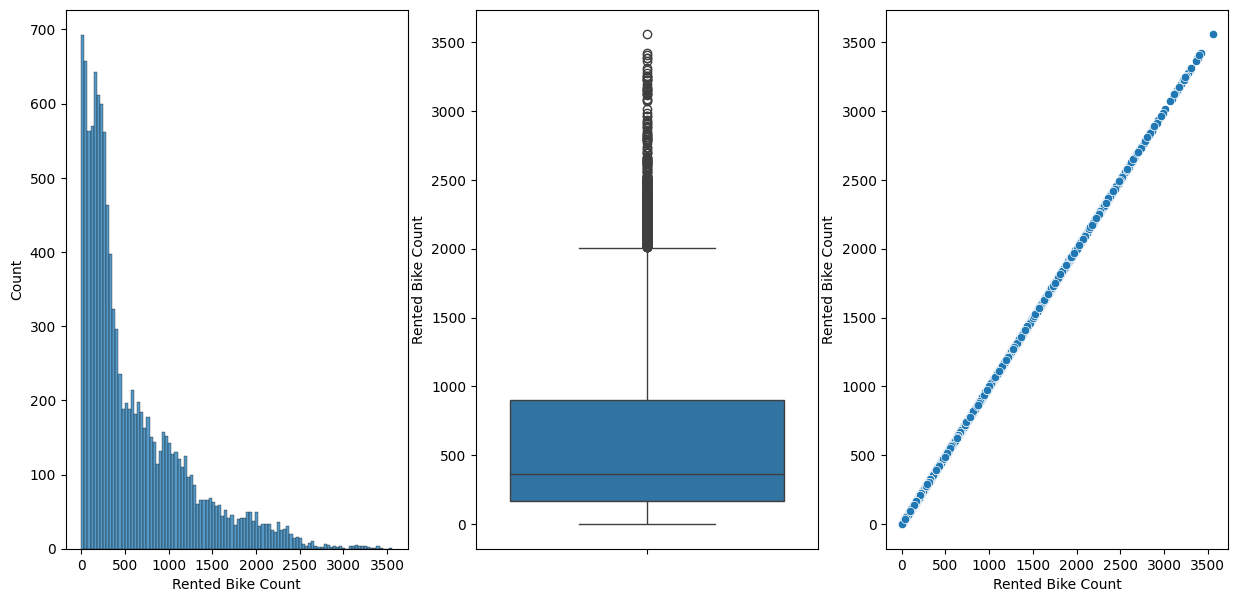

In [11]:
summarize_variable("Rented Bike Count", raw_data)

## Features

#### 'Date' 

Date
Min value:	2017-12-01 00:00:00
Median value:	2018-04-01 00:00:00
Mean value:	2018-05-01 14:00:19.726027520
Max value:	2018-11-30 00:00:00
Std:		106 days 19:46:28.459033526

0 missing values


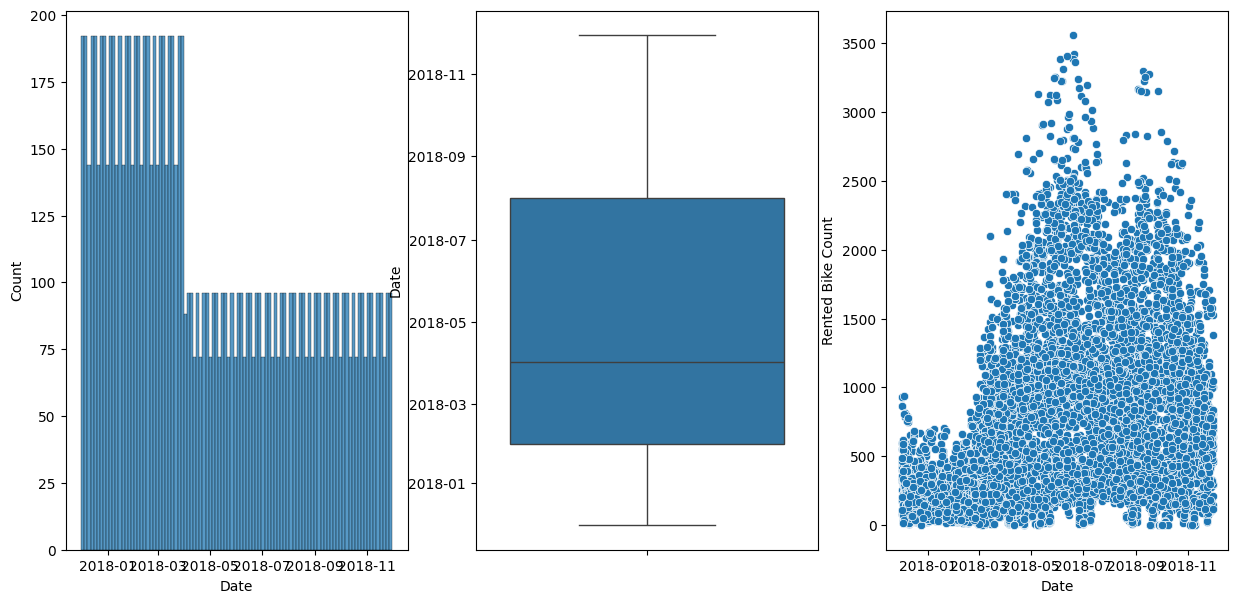

In [12]:
summarize_variable("Date", raw_data)

#### 'Dew point temperature'

Dew point temperature
Min value:	-30.6
Median value:	0.7
Mean value:	0.7520462328767124
Max value:	27.2
Std:		13.496679041806939

0 missing values


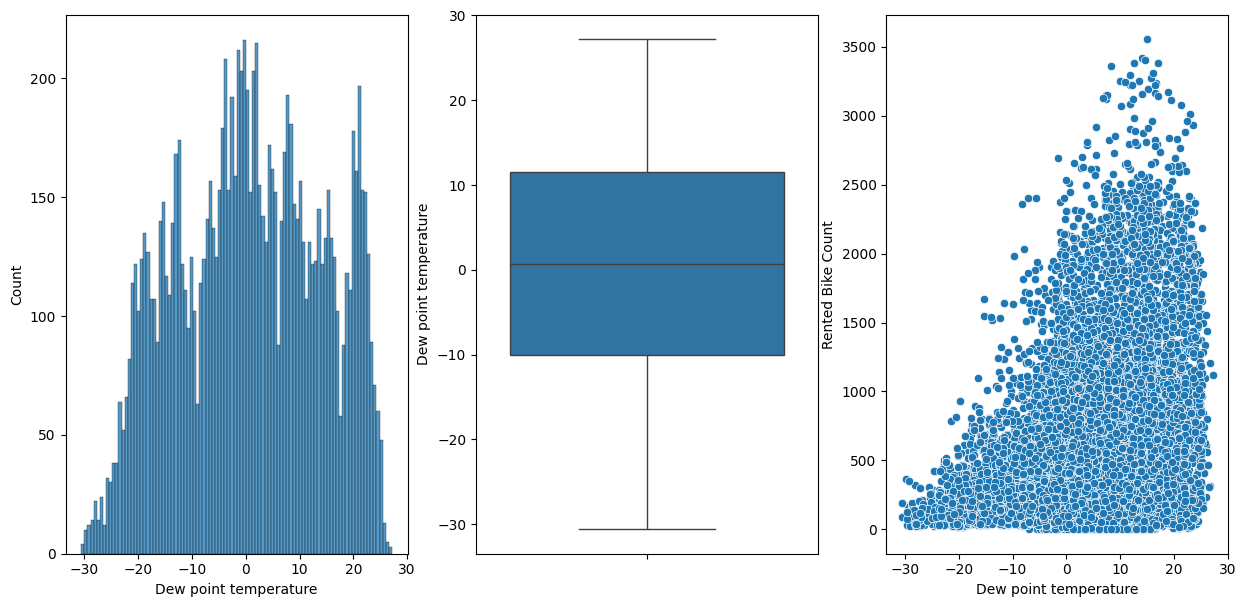

In [13]:
summarize_variable("Dew point temperature", raw_data)

#### 'feat01'

feat01
Min value:	5.978858098387718e-05
Median value:	0.5001075346954167
Mean value:	0.5015117785818428
Max value:	0.9999852376058698
Std:		0.2891547947511783

0 missing values


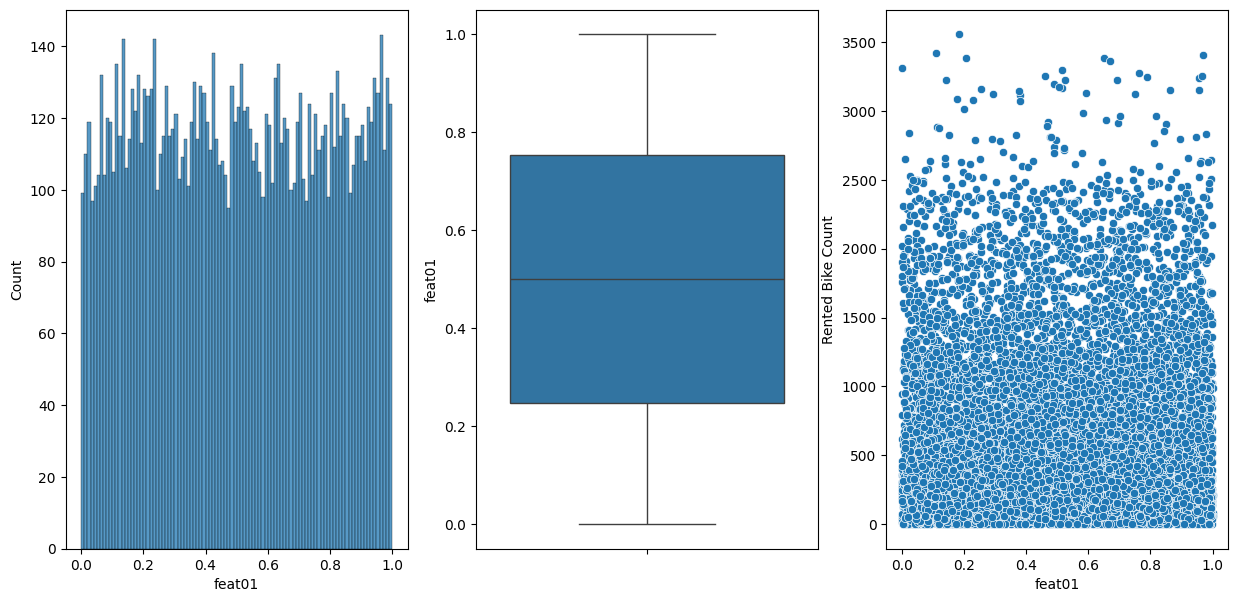

In [14]:
summarize_variable("feat01", raw_data)

#### 'feat02'

feat02
Min value:	5.264393985271454e-05
Median value:	0.4846242102794349
Mean value:	0.4918896621731046
Max value:	0.9999815488699824
Std:		0.2891396467930836

0 missing values


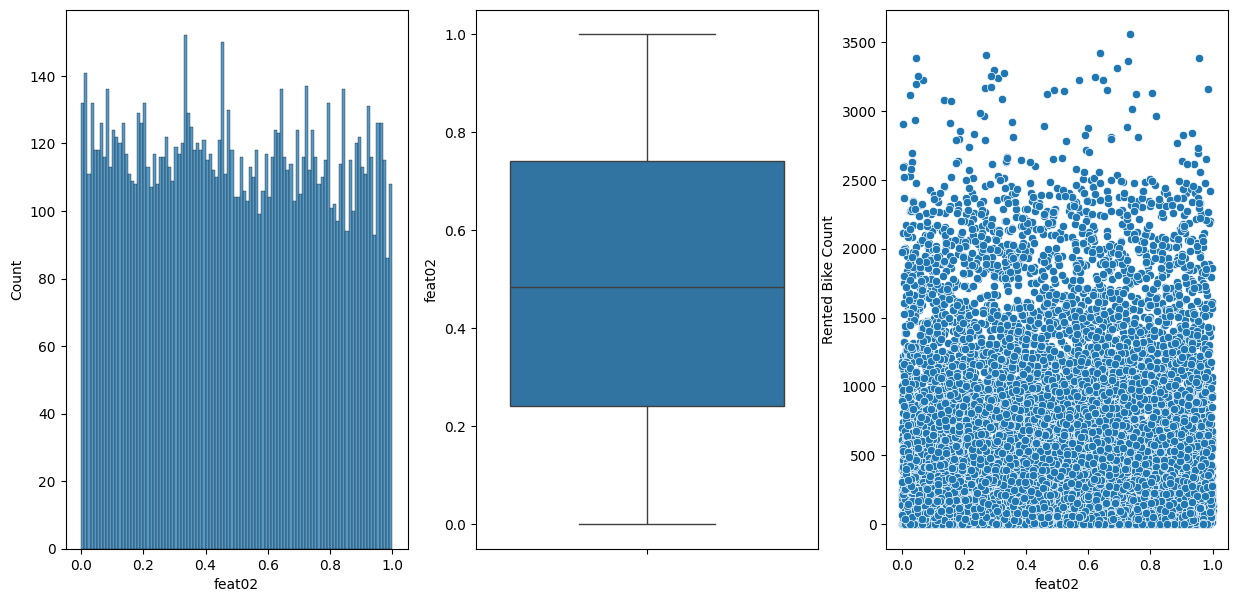

In [15]:
summarize_variable("feat02", raw_data)

#### 'feat03'

feat03
Min value:	4.149111919105053e-05
Median value:	0.4897291760426014
Mean value:	0.49517760247090586
Max value:	0.9999934528023005
Std:		0.28847169672001

0 missing values


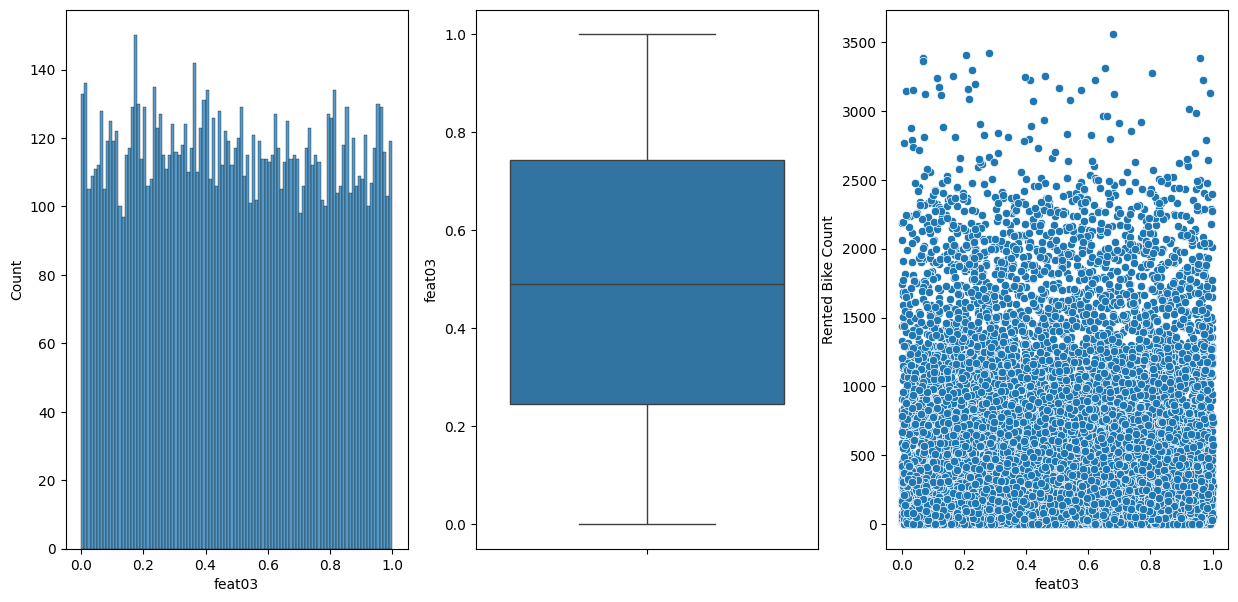

In [16]:
summarize_variable("feat03", raw_data)

#### 'feat04'

feat04
Min value:	3.764871507883072e-05
Median value:	0.503993175807409
Mean value:	0.5038738397218977
Max value:	0.9999976560939104
Std:		0.2895977352387037

0 missing values


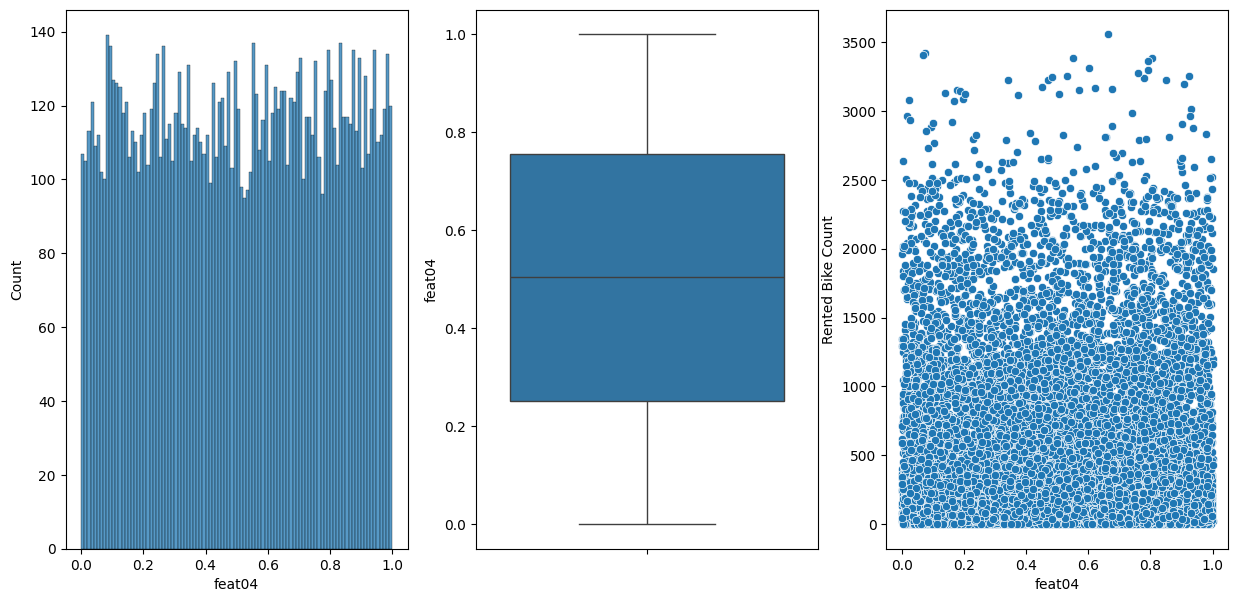

In [17]:
summarize_variable("feat04", raw_data)

#### 'feat05'

feat05
Min value:	0.0003125453367829323
Median value:	0.5029590857448056
Mean value:	0.5011215319683375
Max value:	0.999841598328203
Std:		0.2893186895063003

0 missing values


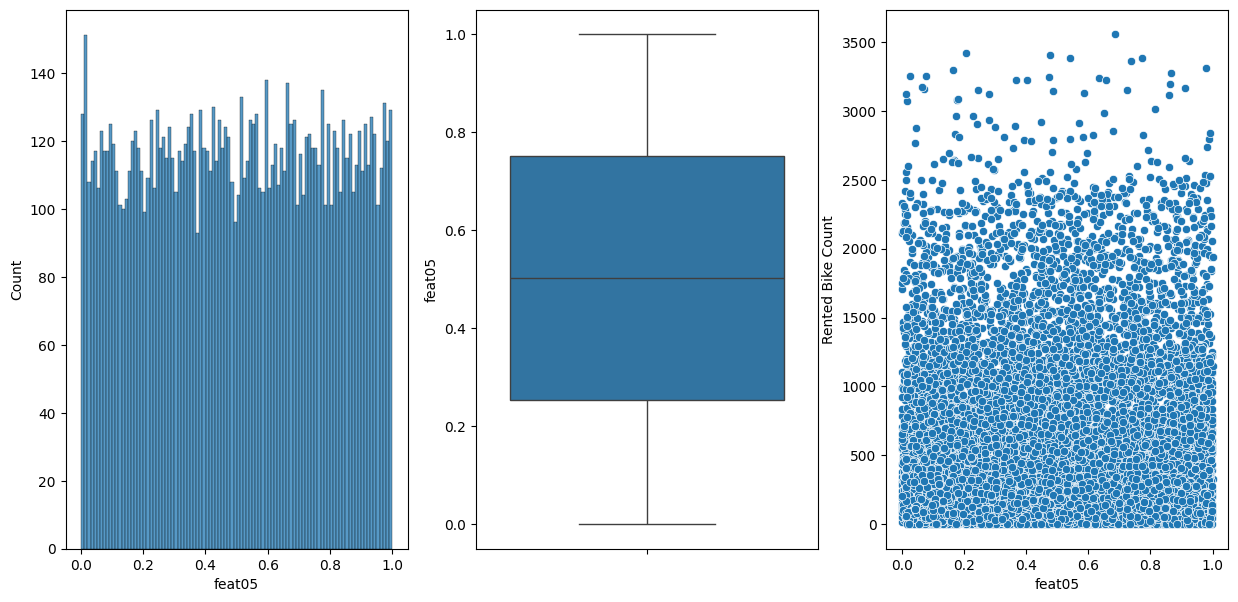

In [18]:
summarize_variable("feat05", raw_data)

#### 'feat06'

feat06
Min value:	0.0004632496275007725
Median value:	0.5121707512298599
Mean value:	0.5043441070898552
Max value:	0.9999285792000592
Std:		0.28938433322581264

0 missing values


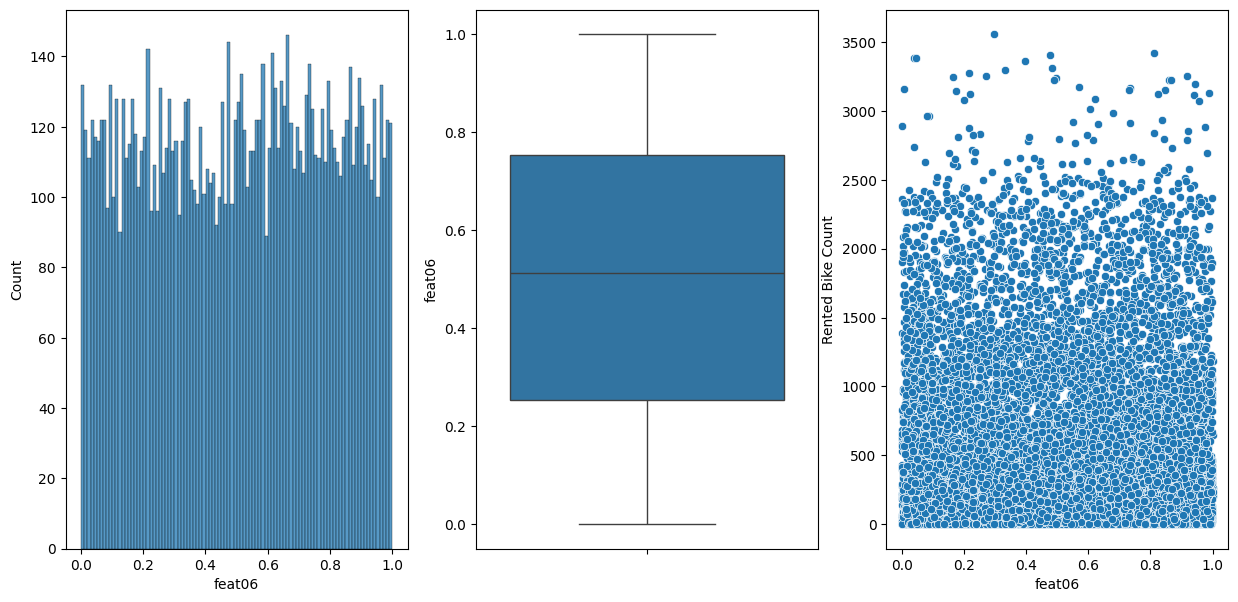

In [19]:
summarize_variable("feat06", raw_data)

#### 'feat07'

feat07
Min value:	0.0
Median value:	0.507534833325539
Mean value:	0.5063518165198988
Max value:	1.0
Std:		0.12445559646152177

0 missing values


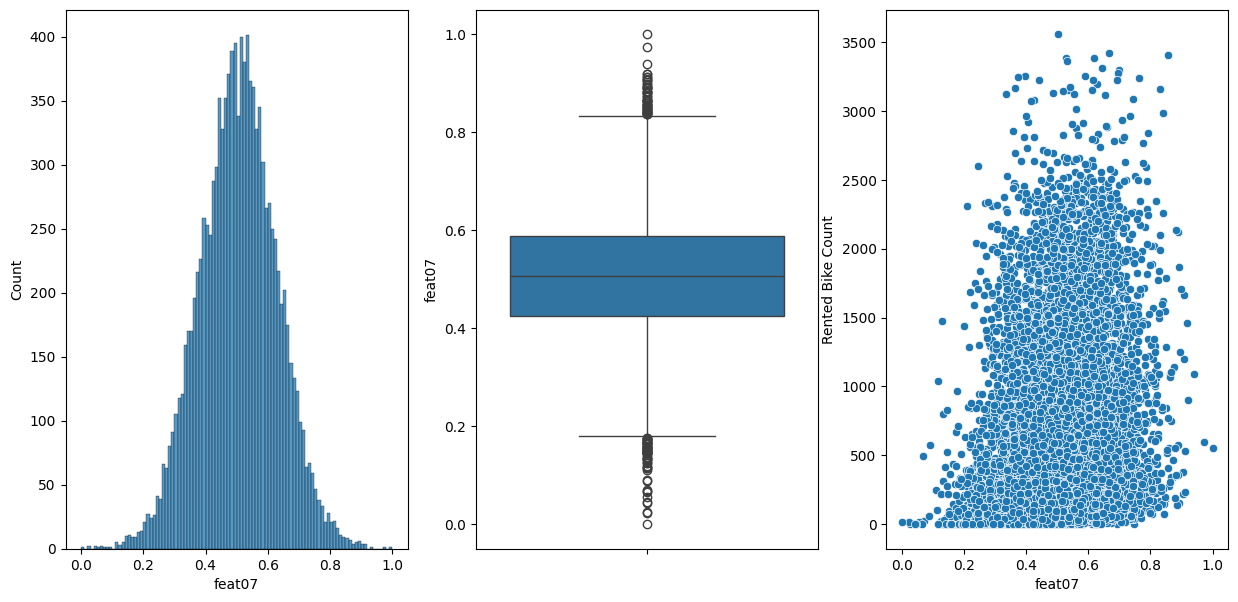

In [20]:
summarize_variable("feat07", raw_data)

#### 'feat08'

feat08
Min value:	0.0
Median value:	0.4756086702064089
Mean value:	0.4773770007736473
Max value:	1.0
Std:		0.12862658541179736

0 missing values


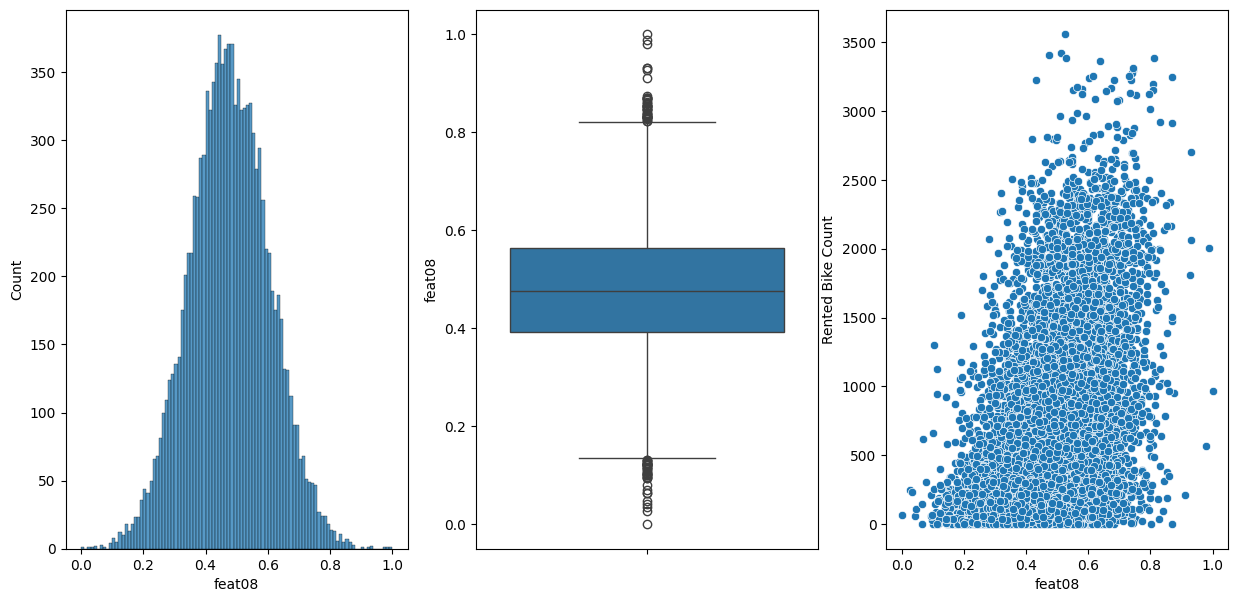

In [21]:
summarize_variable("feat08", raw_data)

#### 'feat10'

feat10
Min value:	0.00012585963122546673
Median value:	0.49804327997844666
Mean value:	0.4971475210580225
Max value:	0.9998753420077264
Std:		0.2875050198529709

0 missing values


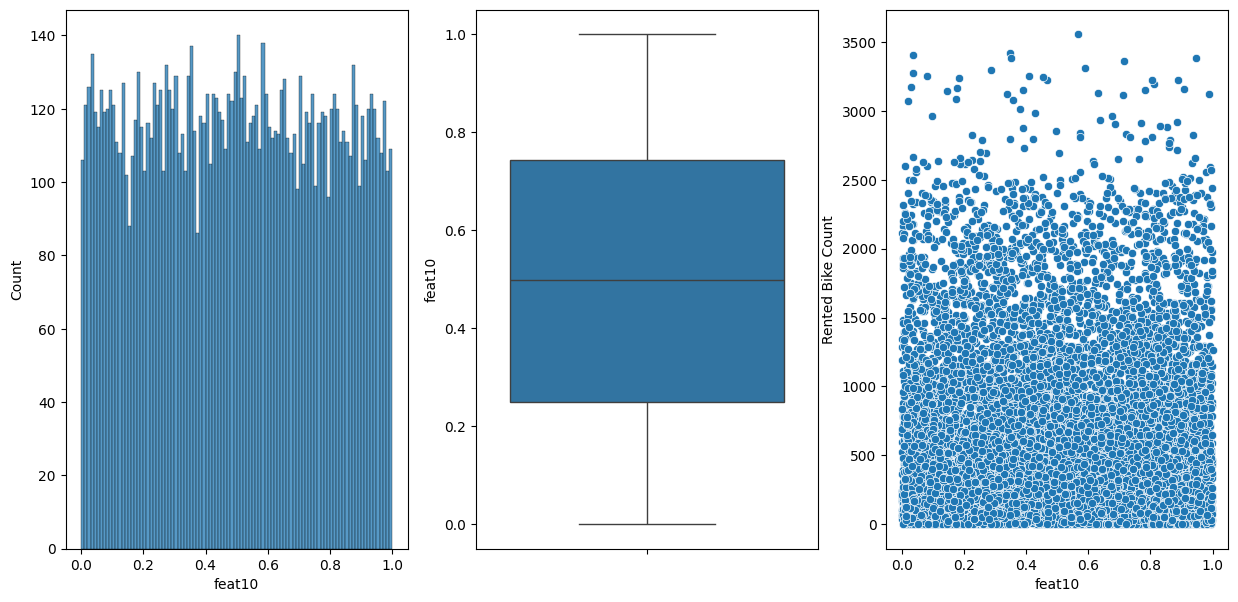

In [22]:
summarize_variable("feat10", raw_data)

#### 'feat' columns observations

We can see that values for the columns feat01, feat02, feat03, feat04, feat05, feat06, feat07, feat08, feat10 are all between 0 and 1 and distributions differ between some of them. We do not know which of those columns present data relevant to the analyzed problem because we lack descriptions of them, thus we will need to apply feature selection to determine if any should be included in our analysis

#### 'Functioning Day'

Functioning Day
Unique values:
['Yes', 'No']
Number of unique values: 2

0 missing values


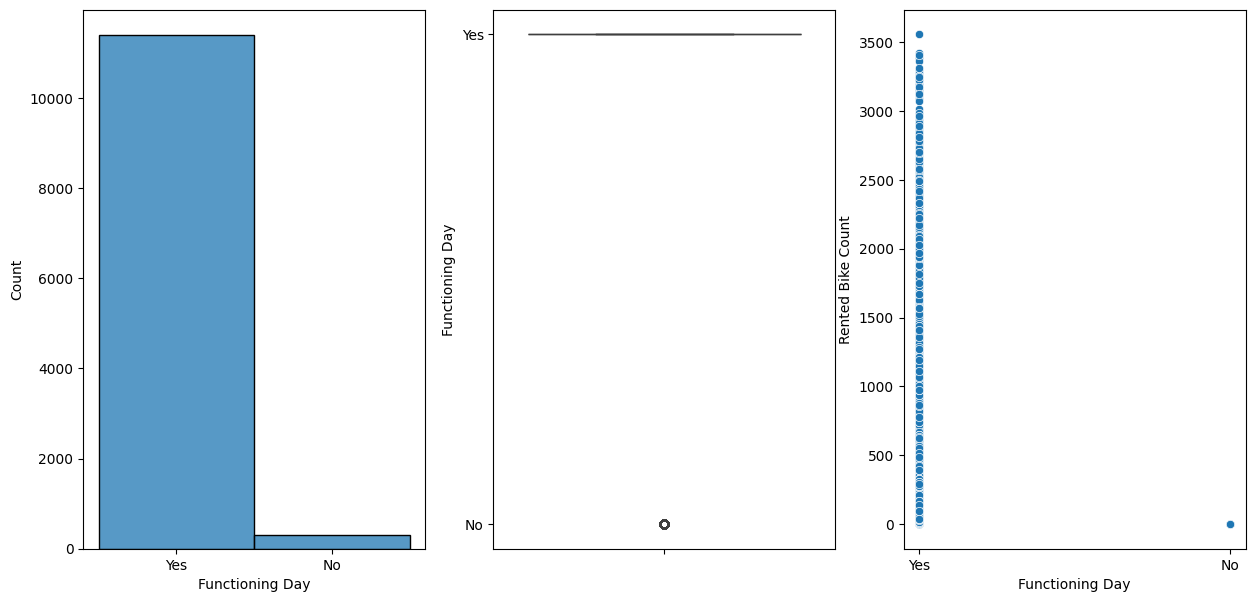

In [23]:
summarize_variable("Functioning Day", raw_data, cat=True)

'Functioning Day' column contians text labels, but it is binary, thus we will apply label encoding later

#### 'Holiday'

Holiday
Unique values:
['No Holiday', 'Holiday']
Number of unique values: 2

0 missing values


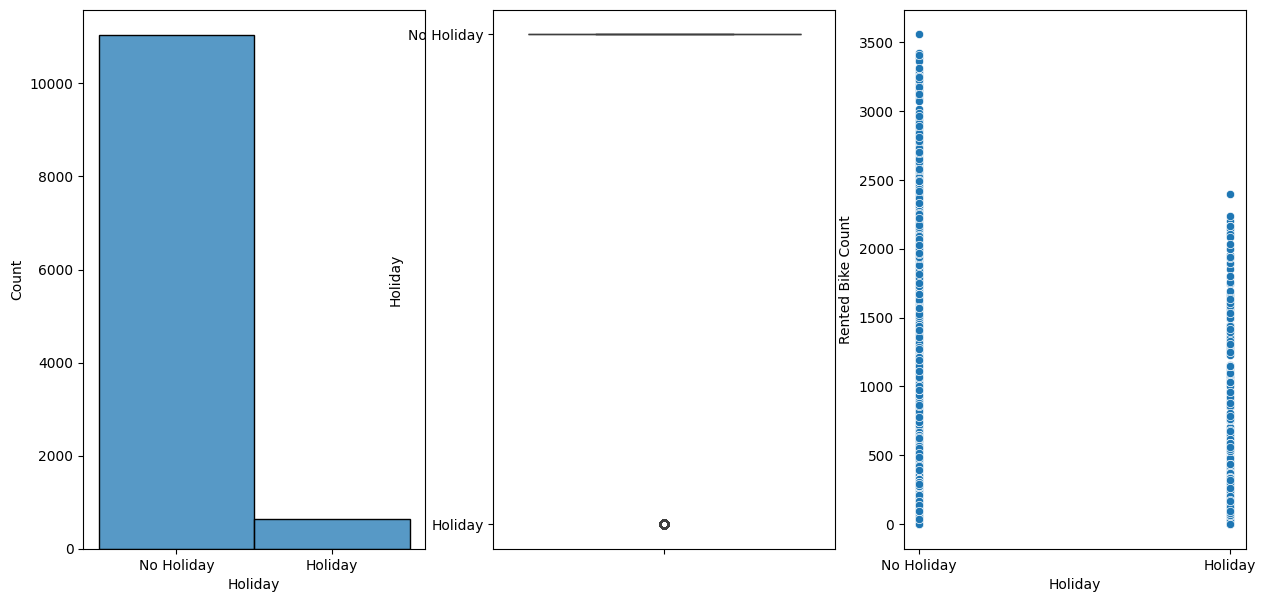

In [24]:
summarize_variable("Holiday", raw_data, cat=True)

'Holiday' column contians text labels, but it is also binary, thus we will again apply label encoding 

#### 'Hour'

Hour
Unique values:
[8, 7, 22, 21, 13, 14, 9, 20, 4, 2, 3, 18, 12, 5, 16, 1, 6, 19, 23, 17, 0, 11, 10, 15]
Number of unique values: 24

0 missing values


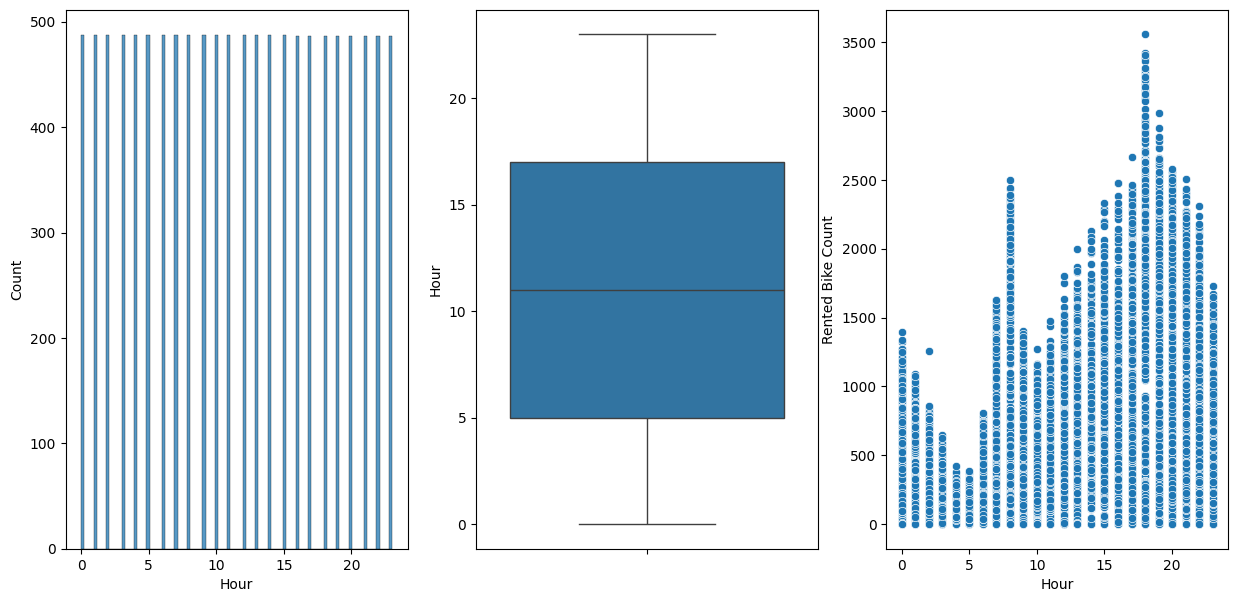

In [25]:
summarize_variable("Hour", raw_data, cat=True)

'Hour' column contains data from 0 to 23, however we cannot leave it as it is because it will imply order in the data. We will need to consider the fact that the data is circular - 0 is closer to 23 than to 12. Applying one-hot encoding will not be feasable as it will drastically increase our dimensionality. This column will require some transformations

#### 'Humidity'

Humidity
Min value:	0
Median value:	55.0
Mean value:	56.73458904109589
Max value:	98
Std:		20.432231584186734

0 missing values


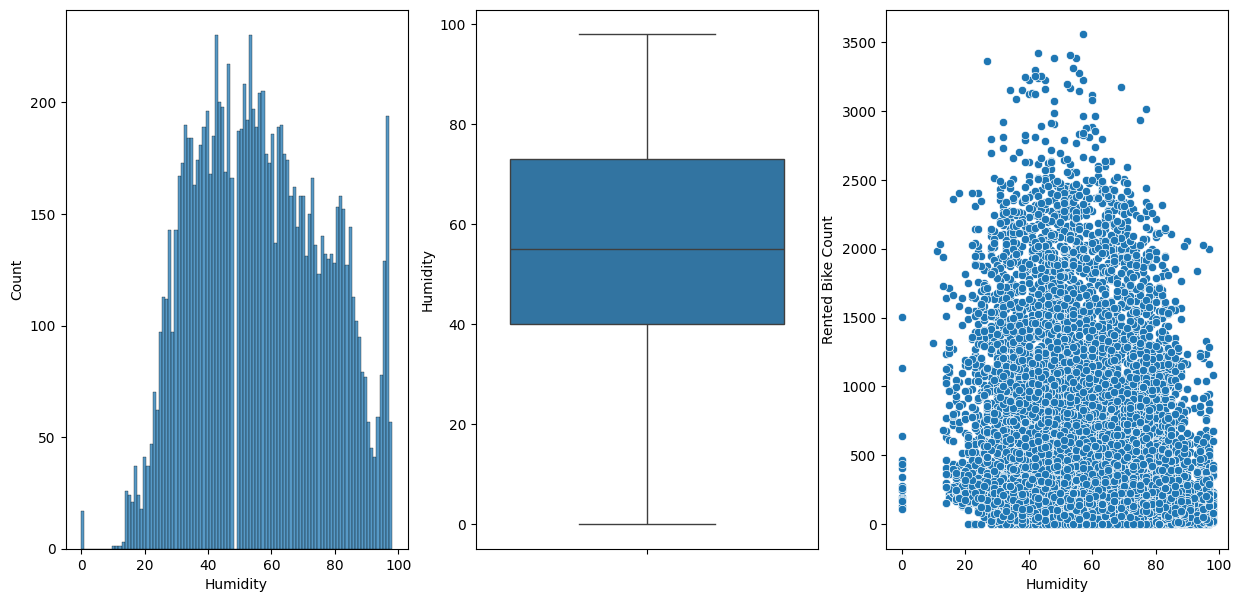

In [26]:
summarize_variable("Humidity", raw_data)


#### 'Rainfall'

Rainfall
Min value:	0.0
Median value:	0.0
Mean value:	0.12199486301369863
Max value:	35.0
Std:		1.0143511501533538

0 missing values


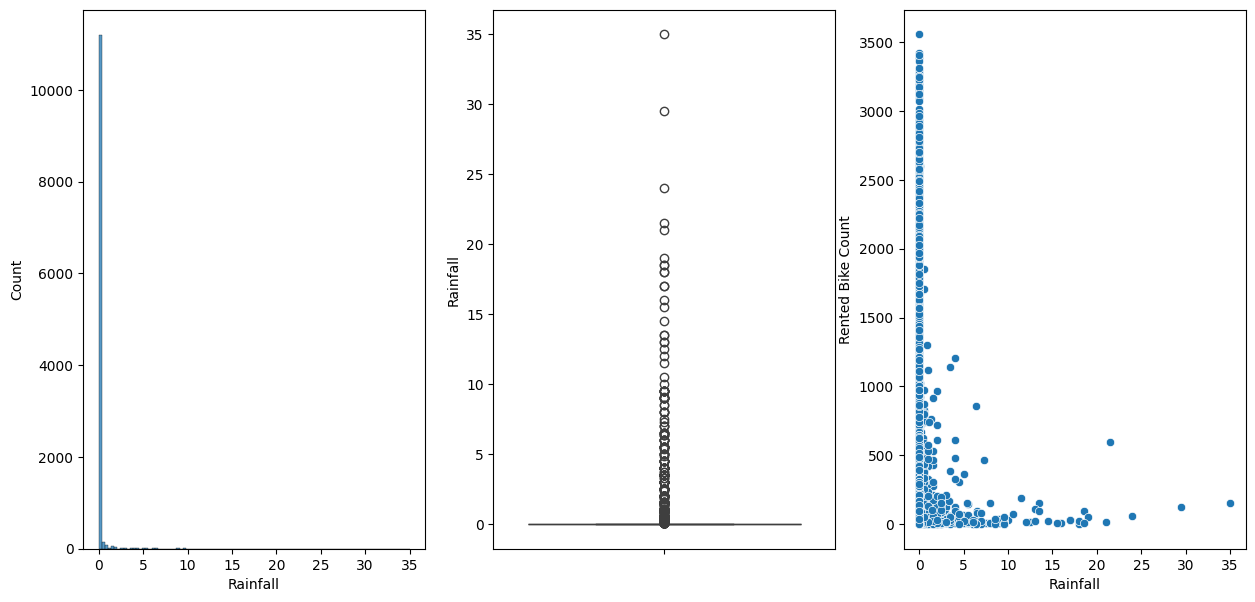

In [27]:
summarize_variable("Rainfall", raw_data)

#### 'Seasons'

Seasons
Unique values:
['Autumn', 'Winter', 'Summer', 'Spring']
Number of unique values: 4

0 missing values


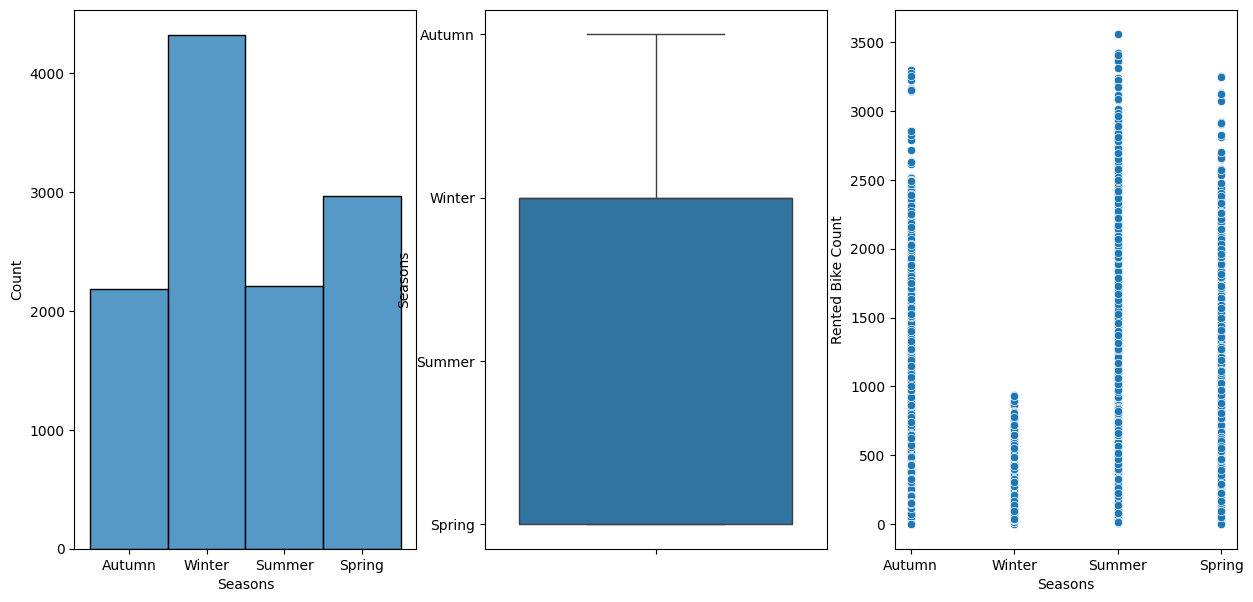

In [28]:
summarize_variable("Seasons", raw_data, cat=True)

For 'Seasons' column we can see that there are 4 possible values. We can apply one-hot encoding for this column to better indicate the season for each observation


#### 'Snowfall'

Snowfall
Min value:	0.0
Median value:	0.0
Mean value:	0.10207191780821918
Max value:	8.8
Std:		0.4882145459698738

0 missing values


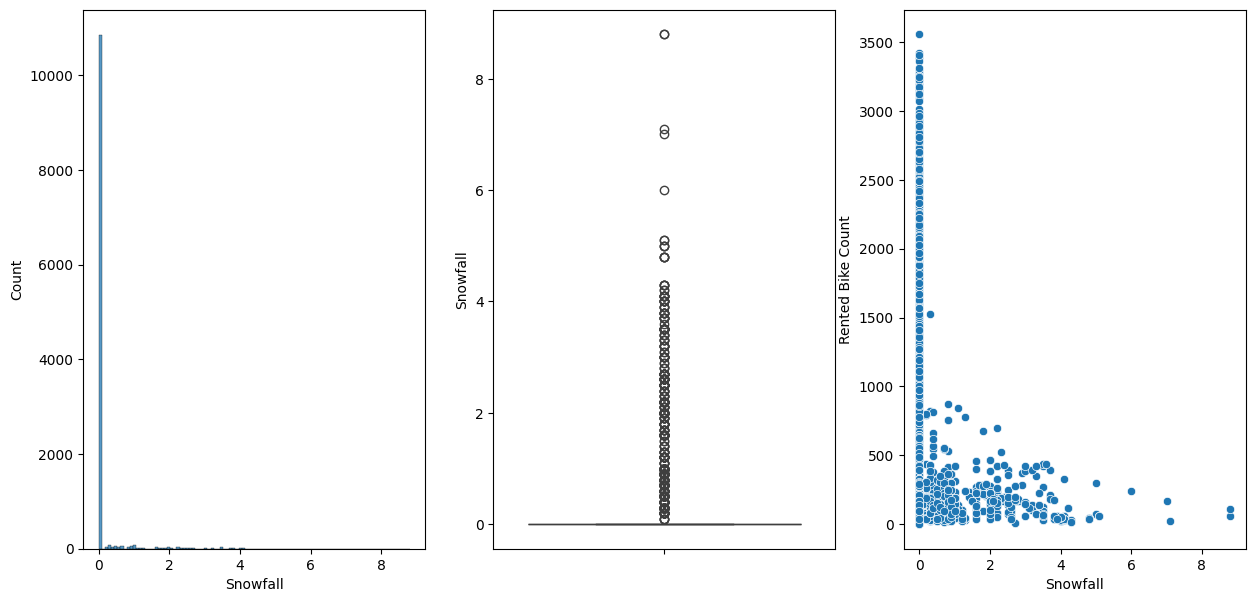

In [29]:
summarize_variable("Snowfall", raw_data)

#### 'Solar Radiation'

Solar Radiation
Min value:	0.0
Median value:	0.0
Mean value:	0.5206892123287671
Max value:	3.52
Std:		0.8237446710869633

0 missing values


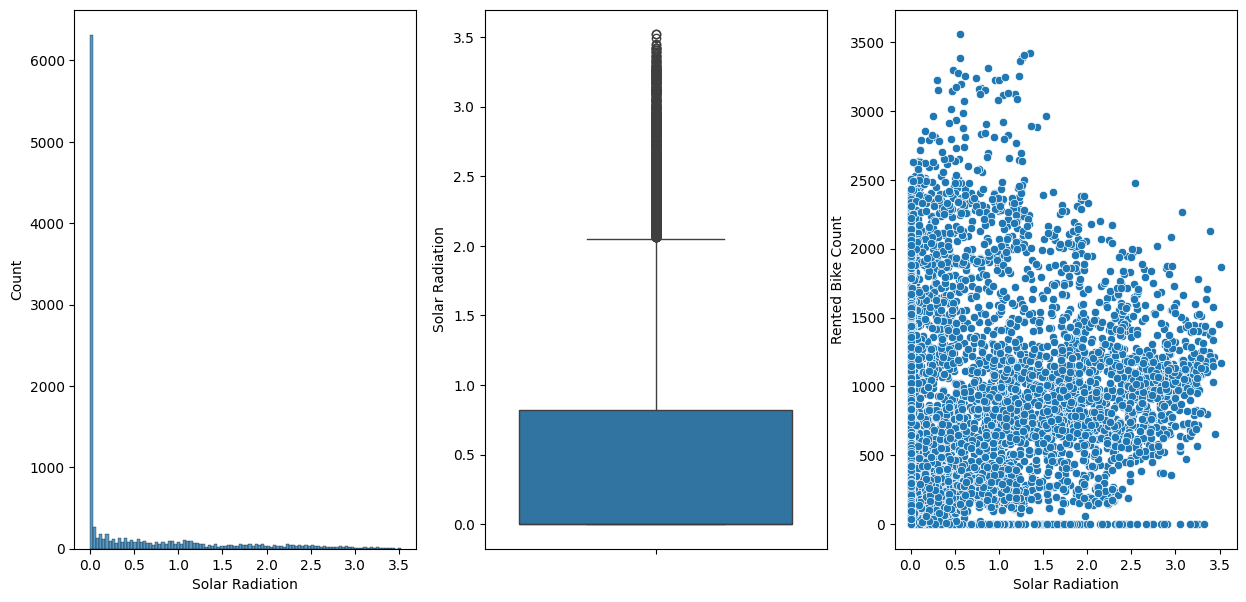

In [30]:
summarize_variable("Solar Radiation", raw_data)

#### 'Temperature'

Temperature
Min value:	-17.8
Median value:	8.5
Mean value:	9.724160958904111
Max value:	39.4
Std:		12.246181508366906

0 missing values


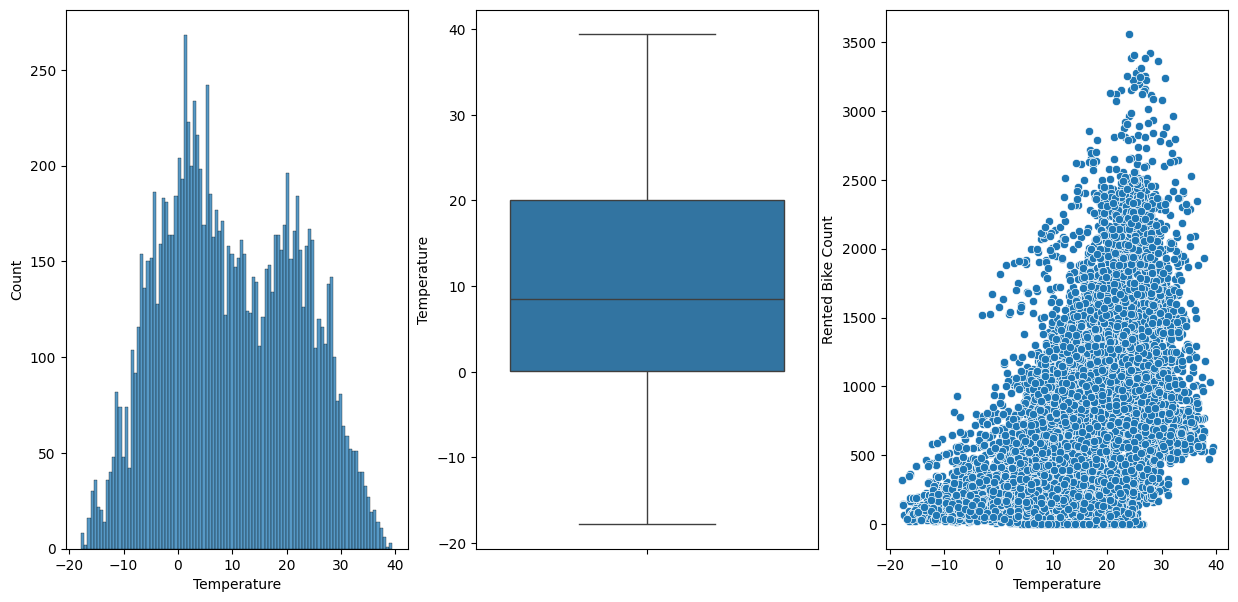

In [31]:
summarize_variable("Temperature", raw_data)

#### 'Visibility'

Visibility
Min value:	27
Median value:	1678.0
Mean value:	1419.1883561643835
Max value:	2000
Std:		619.9620481478108

0 missing values


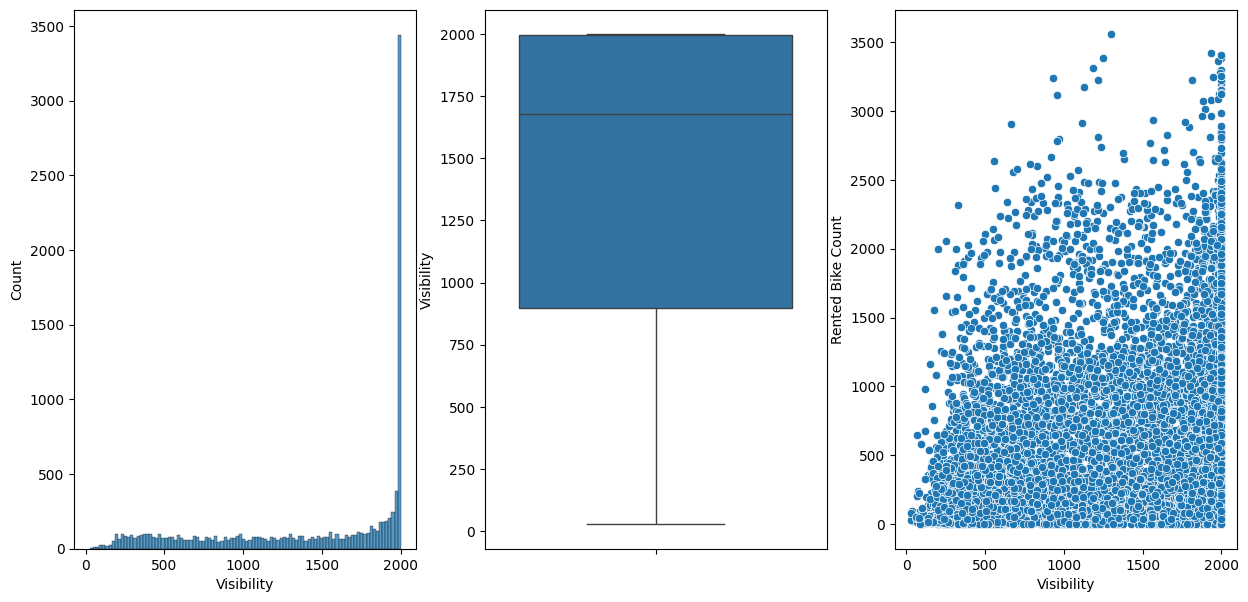

In [32]:
summarize_variable("Visibility", raw_data)

#### 'Wind speed'

Wind speed
Min value:	0.0
Median value:	1.6
Mean value:	1.7734760273972603
Max value:	7.4
Std:		1.0614561577702435

0 missing values


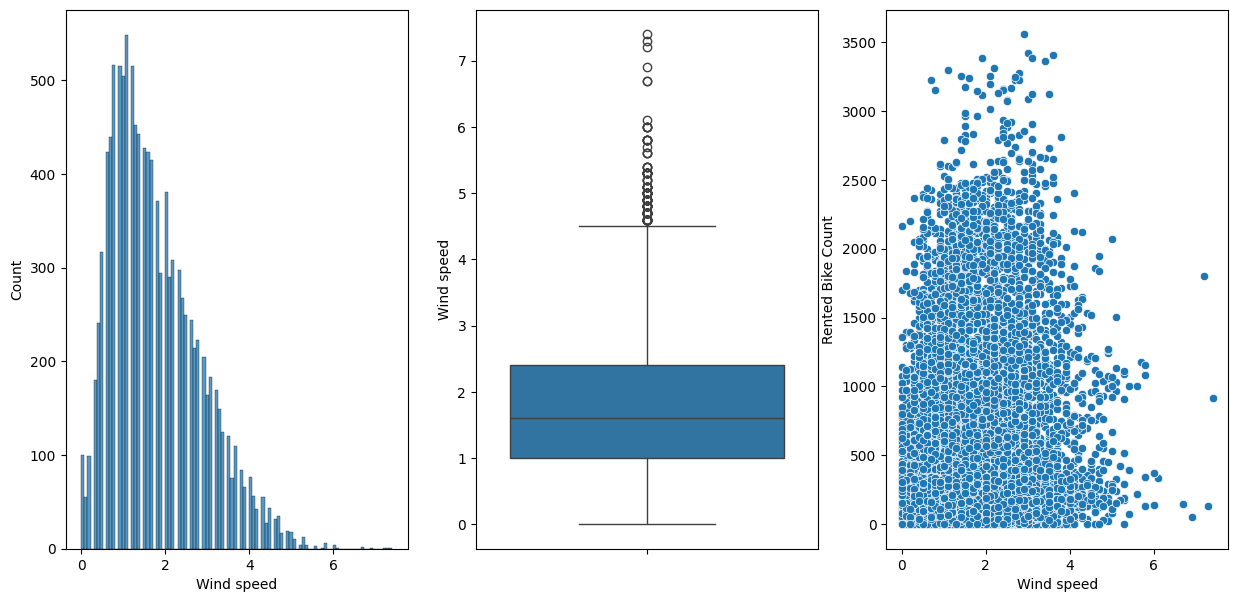

In [33]:
summarize_variable("Wind speed", raw_data)

### Correlation matrix 
We need to check the correlations between the variables to see if there are any strong correlations between the variables. Because we will consider models that handle multicolinearity well we are interested in finding out if there are columns that may be just a transformations of other columns. This will ensure that there are no two features that provide the same information

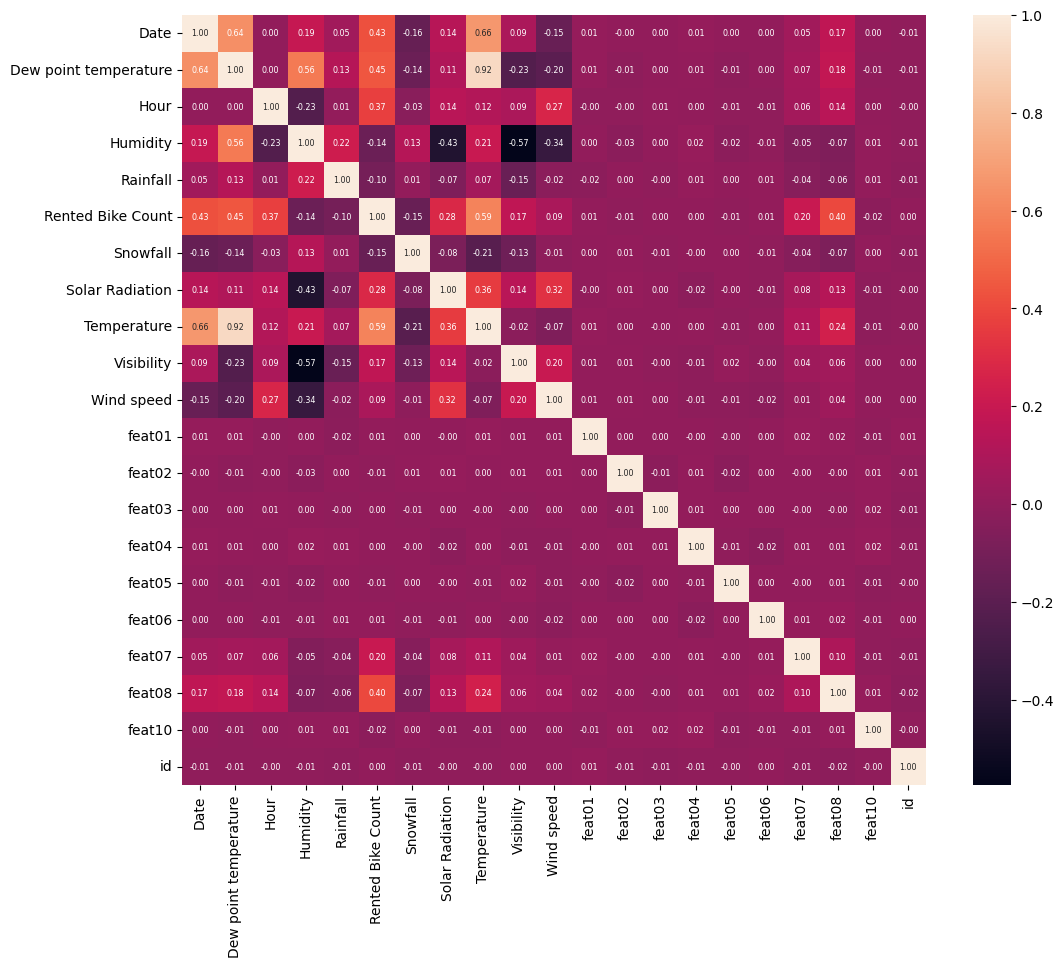

In [34]:
plt.figure(figsize=(12, 10))
sns.heatmap(raw_data[raw_data.columns.difference(["Holiday", "Functioning Day", "Seasons"])].corr(), annot=True, annot_kws={"fontsize": "xx-small"}, fmt=".2f");

As we can see, there are no correclations present that would point to any feature being linear transformation of other

# Data preparation

Steps that we will need to take to prepare our data for the analysis:

- `Encoding` categorical and binary variables, as noted in data inspection section

- `Normalization` of the features (this only applies to the neural network as Decision Trees and XGBoost models can handle non-normalized data)


Because normalization only applies to the neural network, we will not be normalizing our dataset. Instead, we will apply the normalization layer in the neural network.


Categorical variables (with 3 or more possible values) will be **one-hot** encoded, as label encoding would apply artificial ordinal relationship to the categories that may impact the results of the analysis.

Exception to this will be the `hour` column, as we should consider the cyclical property of this feature (on a clock 0 and 23 are close to each other). In this case we will map the variable onto a cicle using *sin* and *cos* transformation. We could argue that the `Seasons` feature also in some way meets this criteria, however, looking at the values of the `Date` column we can see that the data consits only of one year (dec 2017 - nov 2018), thus data for each season was only gathered once per season, making it a better choice to one-hot encode this feature.

Two columns will be created by transforming the values in `Hour` column using the following equations:

$\qquad \sin(\frac{2\pi}{24} \times x) \qquad and\qquad \cos(\frac{2\pi}{24} \times x) \qquad \text{where x equals value of feature}$

In [35]:
# create copy of the data to keep the original raw data
data_prepared = raw_data.copy()

`Holiday` column label encoding - mapping "Holiday" to 1 and "No Holiday" to 0

In [36]:
holiday_mapping = {"Holiday": 1, "No Holiday": 0}
data_prepared["Holiday"] = data_prepared["Holiday"].map(holiday_mapping)

`Functioning Day` column label encoding - mapping "Yes" to 1 and "No" to 0

In [37]:
functioning_day_mapping = {"Yes": 1, "No": 0}
data_prepared["Functioning Day"] = data_prepared["Functioning Day"].map(functioning_day_mapping)

One-hot endoing of `Seasons` columns - using pandas.get_dummies() function

In [38]:
seasons = pd.get_dummies(data_prepared["Seasons"]).astype(int)
data_prepared = data_prepared.drop("Seasons", axis=1).join(seasons)

Transformation of the `Hour` column into two columns 

In [39]:
data_prepared["hr_sin"] = np.sin(data_prepared["Hour"] * (2. * np.pi / 24))
data_prepared["hr_cos"] = np.cos(data_prepared["Hour"] * (2. * np.pi / 24))

In [40]:
data_prepared = data_prepared.drop("Hour", axis=1)

In [41]:
data_prepared.dtypes

id                                int64
Date                     datetime64[ns]
Dew point temperature           float64
feat01                          float64
feat02                          float64
feat03                          float64
feat04                          float64
feat05                          float64
feat06                          float64
feat07                          float64
feat08                          float64
feat10                          float64
Functioning Day                   int64
Holiday                           int64
Humidity                          int64
Rainfall                        float64
Rented Bike Count                 int64
Snowfall                        float64
Solar Radiation                 float64
Temperature                     float64
Visibility                        int64
Wind speed                      float64
Autumn                            int64
Spring                            int64
Summer                            int64


We will discard `id` and `Date` columns as they do not provide relevant information for the models - for our problem both can be considered as an identification of a given observation in the dataset

In [42]:
data_prepared = data_prepared.drop(["id", "Date"], axis=1)

We are left with 26 columns, all with numeric values

Again, we will check the heatmap with feature transformations applied

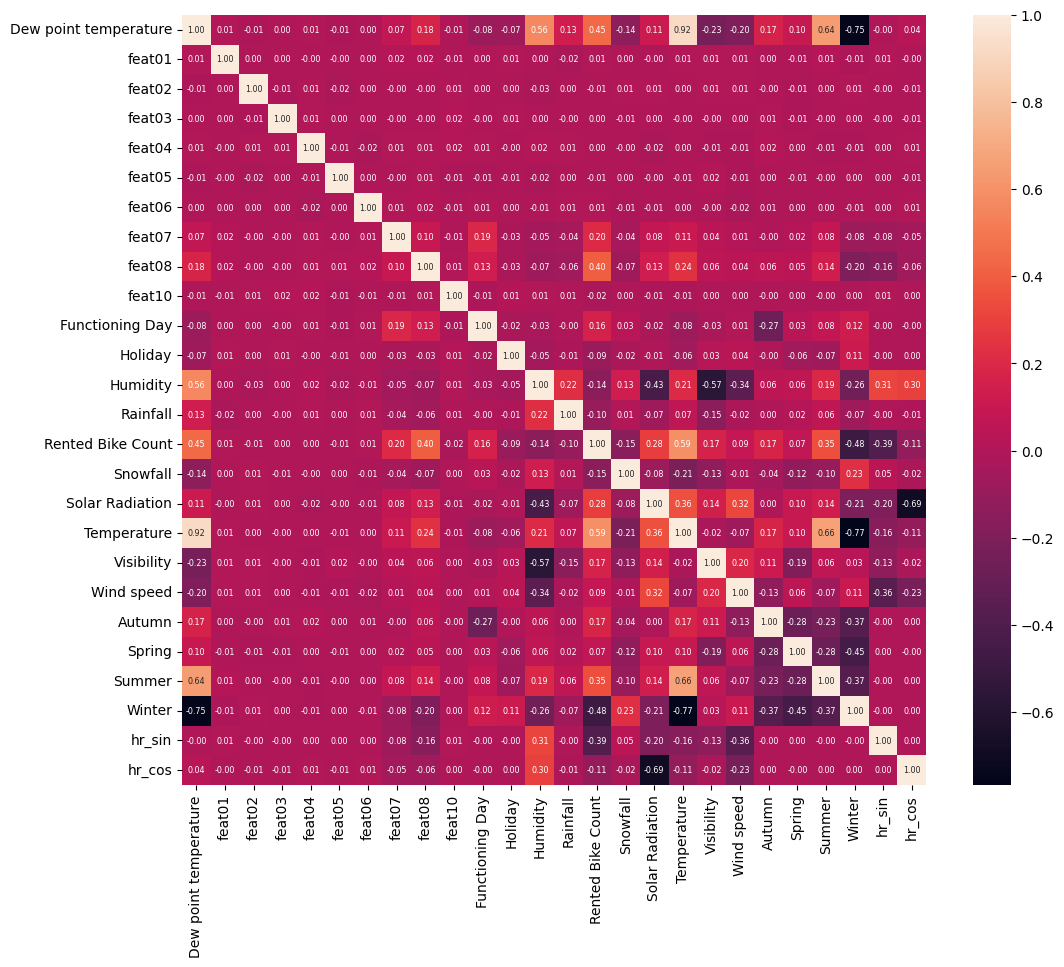

In [43]:
plt.figure(figsize=(12, 10))
sns.heatmap(data_prepared.corr(), annot=True, annot_kws={"fontsize": "xx-small"}, fmt=".2f");

No further preprocessing is needed

# Building the models 

## Split into training and testing sets

We will use 80% of the data as a training set and 20% as testing set

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data_prepared.drop("Rented Bike Count", axis=1), data_prepared["Rented Bike Count"], test_size=0.2, random_state=42)

## Feature selection

As mentioned, we will apply feature selection to determine which features are relevant to our problem. For this we will use Mutual Information score. 

In [45]:
mi_scores = mutual_info_regression(X_train, y_train, random_state=42)
mi_scores

array([0.48961414, 0.0085265 , 0.        , 0.00691764, 0.        ,
       0.01798543, 0.00103726, 0.04595761, 0.0977611 , 0.01578722,
       0.10773755, 0.01761732, 0.29367544, 0.04895658, 0.10087012,
       0.28679089, 0.66224264, 0.21070195, 0.20816289, 0.07090755,
       0.04305803, 0.07308171, 0.26649579, 0.34256201, 0.28983015])

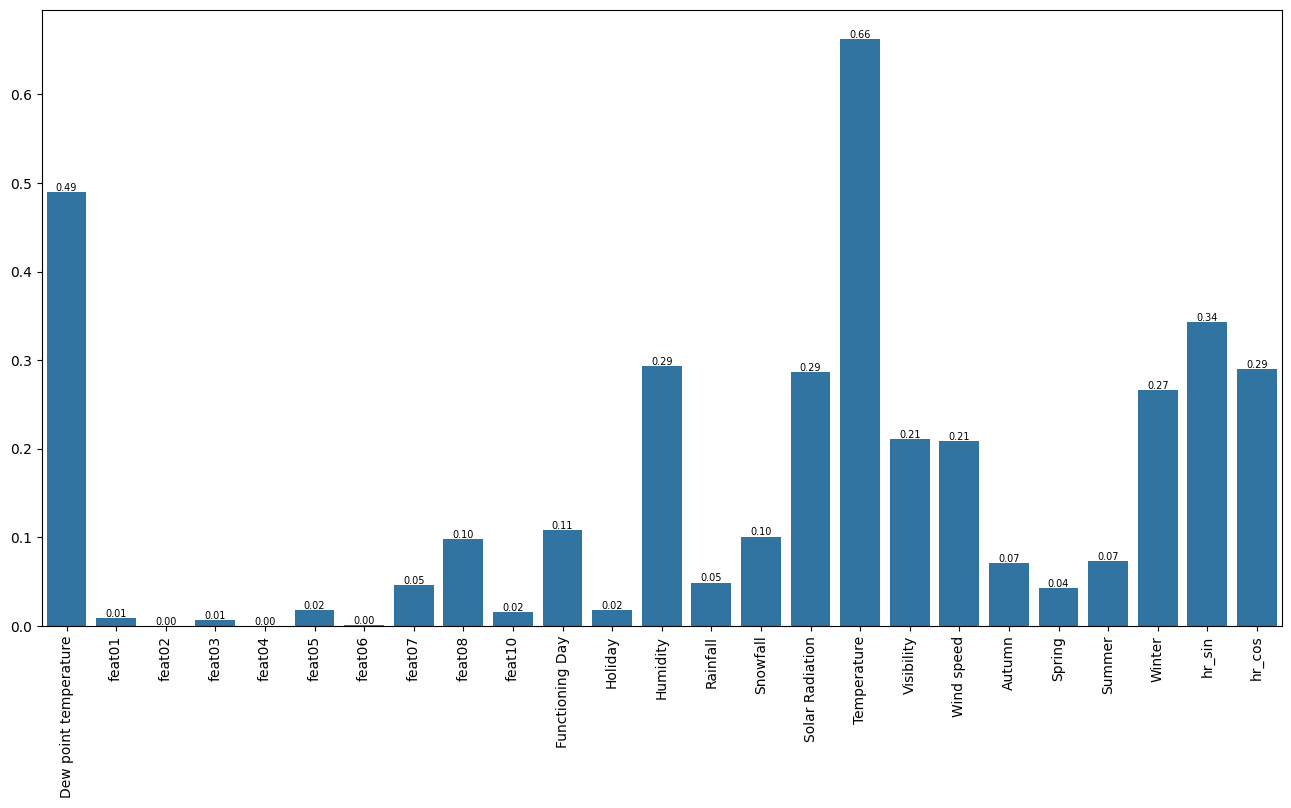

In [46]:
plt.figure(figsize=(16,8))
ax = sns.barplot(y=mi_scores, x=X_train.columns.to_list())
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(
        f'{height:.2f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='center', fontsize=7, color="black"
    )
plt.xticks(rotation=90)
plt.show()

The feature selection step is here mainly to determine which of the `feat` features are relevant, we do not want to discard high amount of columns. Because of that we will select all features for whom the MI score is higher than 0.01 - thus leaving 20 features

In [47]:
features = [i for i, score in enumerate(mi_scores) if round(score,2)> 0.01]
X_train = X_train.iloc[:,features]
X_test = X_test.iloc[:, features]

## Decision Tree Regressor

### Pre-pruning

In our first approach to create Decision Tree model we will utilize pre-prunnig by evaulating multiple values of selected hyperparameters using GridSearchCV

In [48]:
# Define the parameter space for the grid search
param_space = {
    "criterion": ["squared_error", "friedman_mse", "absolute_error"],
    "max_depth": np.arange(8, 25, 2),
    "min_samples_split": np.arange(2, 10, 2),
    "min_samples_leaf": np.arange(1, 8, 2),
    "max_features": [None, "sqrt", "log2"]
}

In [49]:
# Initialize the grid search model
grid_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), param_space, cv=5, n_jobs=-1, verbose=1)

In [50]:
# Fit the model
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/Users/mtomczak/Documents/Sem9/machine learning/project/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': array([ 8, 10, 12, 14, 16, 18, 20, 22, 24]),
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': array([1, 3, 5, 7]),
                         'min_samples_split': array([2, 4, 6, 8])},
             verbose=1)

##### Best model found using grid search

In [51]:
# Best model parameters
grid_cv.best_params_

{'criterion': 'squared_error',
 'max_depth': np.int64(12),
 'max_features': None,
 'min_samples_leaf': np.int64(5),
 'min_samples_split': np.int64(2)}

In [52]:
# Best model
pre_prun_dt = grid_cv.best_estimator_

##### Visualizations

Tree

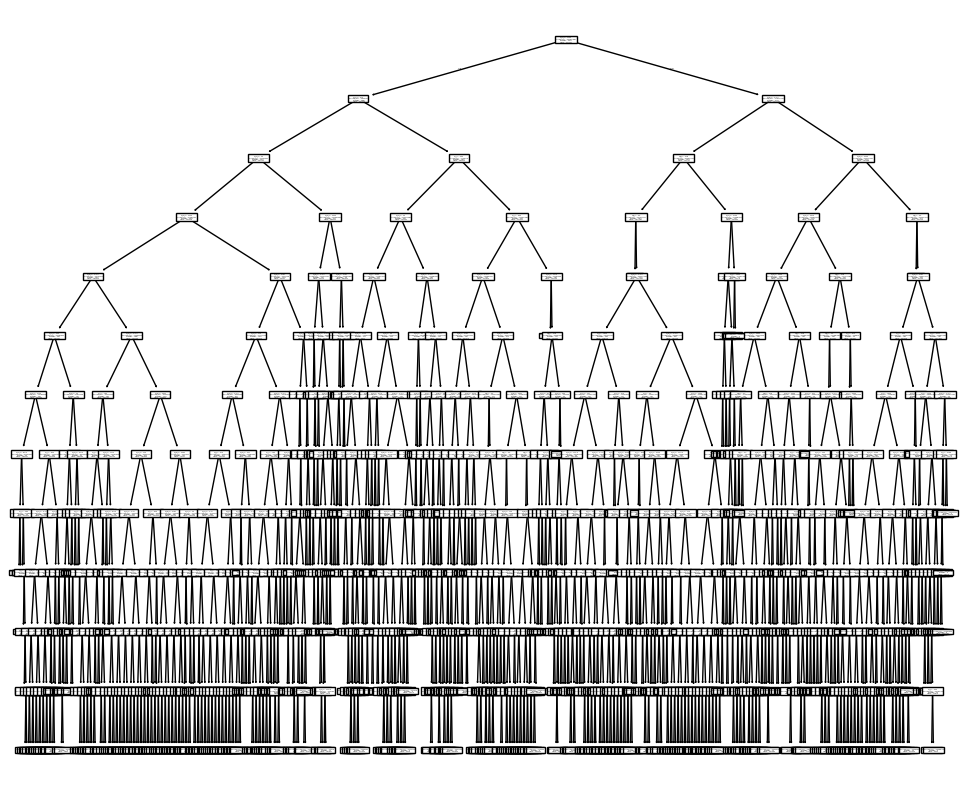

In [53]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_tree(pre_prun_dt);

Feature importances

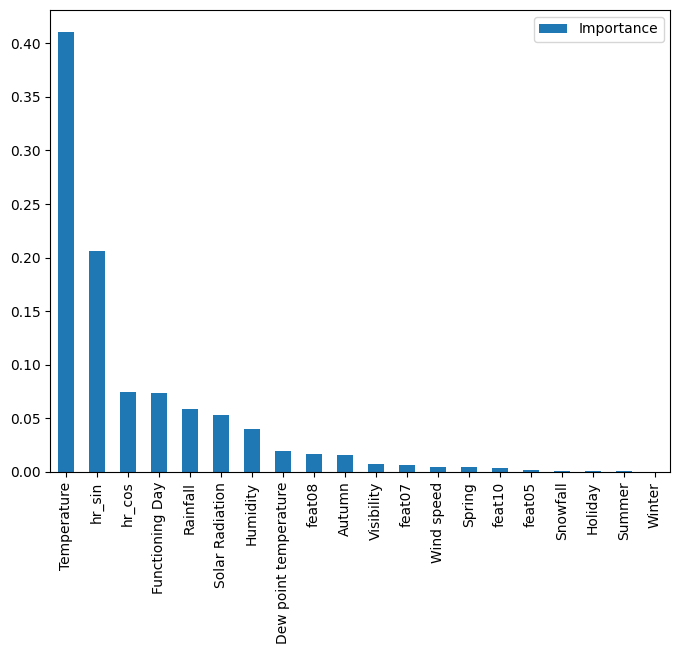

In [54]:
feat_importances = pd.DataFrame(pre_prun_dt.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6));


##### Calculating the scores

In [55]:
pre_prun_dt_preds_train = pre_prun_dt.predict(X_train)
pre_prun_score_train = get_performance_metrics(y_train, pre_prun_dt_preds_train)
pre_prun_score_train

{'MSE': 25246.98, 'RMSE': 158.89, 'R2': 0.93, 'MAE': 93.64}

In [56]:
pre_prun_dt_preds = pre_prun_dt.predict(X_test)
pre_prun_score = get_performance_metrics(y_test, pre_prun_dt_preds)
pre_prun_score

{'MSE': 63545.69, 'RMSE': 252.08, 'R2': 0.82, 'MAE': 144.82}

### Post-pruning

In our second approach will utilize post-pruning. Here we will use complexity pruning path to find value of `ccp_alpha` that maximizes the test score (R2)

In [57]:
# Create full-grown Decision Tree
dt = DecisionTreeRegressor(random_state=42, max_depth=50, min_samples_leaf=2)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=50, min_samples_leaf=2, random_state=42)

In [58]:
# Get values of ccp_alpha 
ccp = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = ccp.ccp_alphas
ccp_impurities = ccp.impurities

In [59]:
# Evaluate models for all possible ccp_alpha values
from IPython.display import clear_output
trees = []
for idx, ccp_alpha in enumerate(ccp_alphas):
    tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
    clear_output(wait=True)
    print(f"{idx + 1}/{len(ccp_alphas)}")

3655/3655


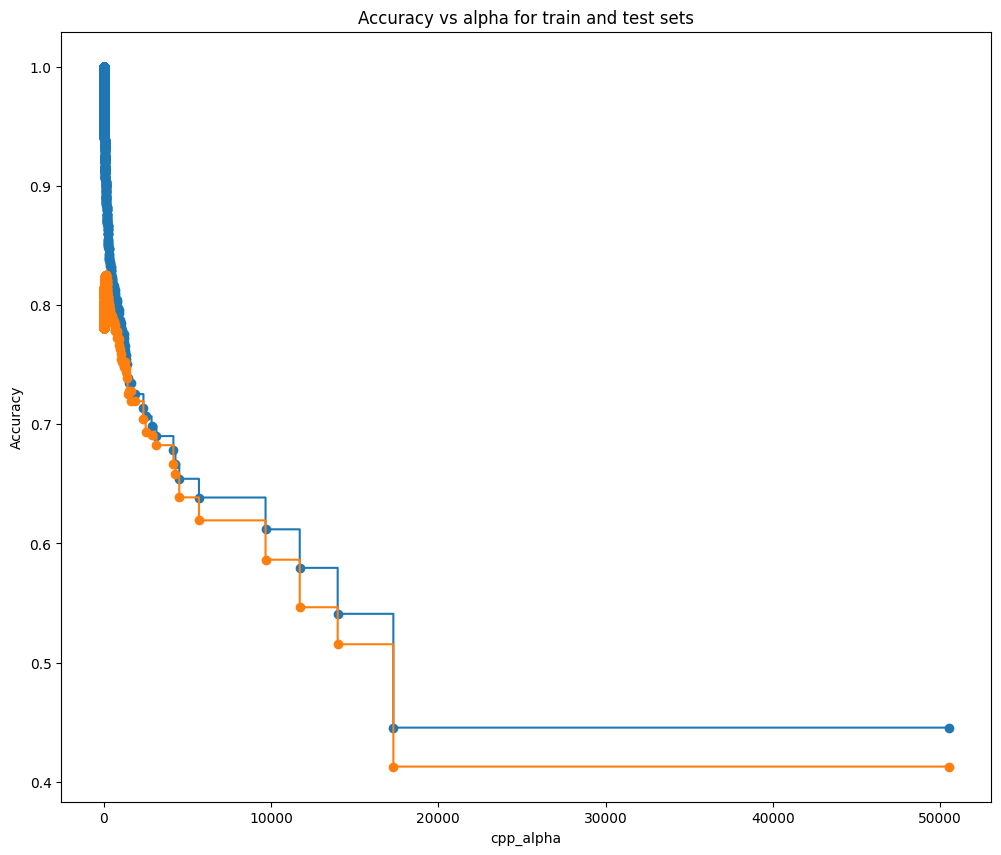

In [60]:
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xlabel("cpp_alpha")
ax.set_ylabel("Accuracy")
plt.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="Train Score", drawstyle="steps-post")
plt.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="Test Score", drawstyle="steps-post")
plt.title("Accuracy vs alpha for train and test sets")
plt.show()

In [61]:
best_alpha = ccp_alphas[np.argmax(test_scores)]
best_alpha

np.float64(121.3017694063924)

Best value of alpha based on our analysis is equal to around `121.3`

Close-up of the above graph

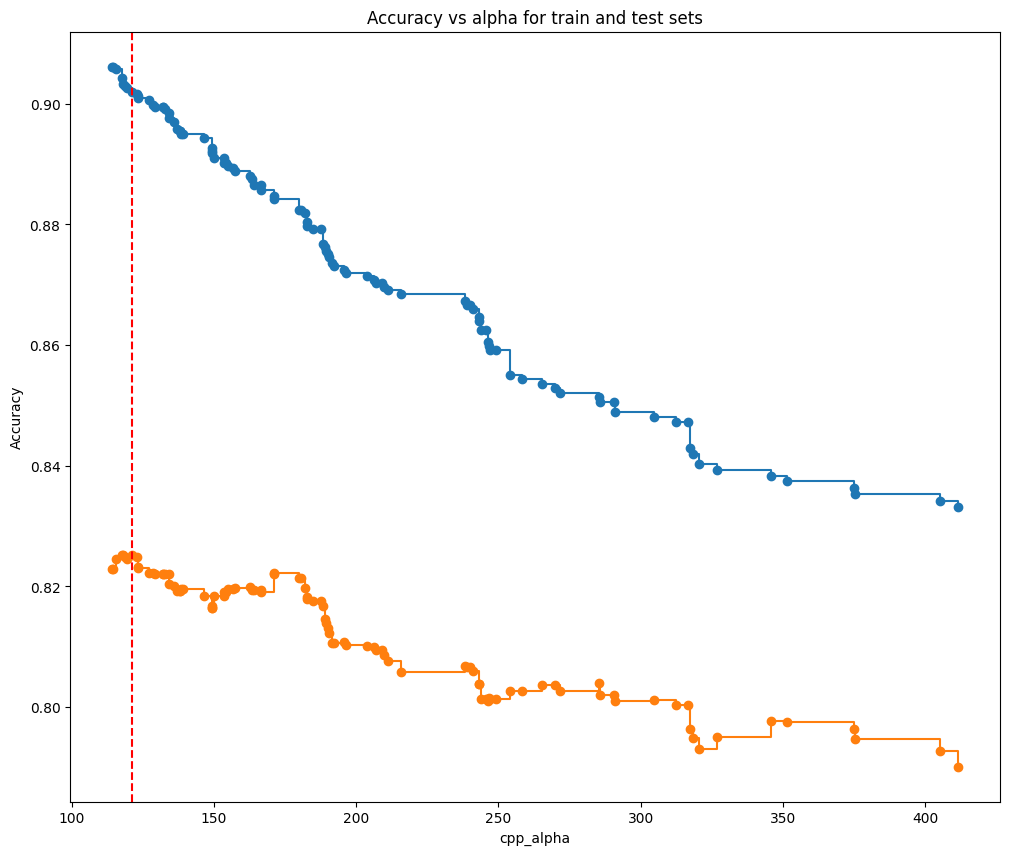

In [62]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xlabel("cpp_alpha")
ax.set_ylabel("Accuracy")
plt.plot(ccp_alphas[3500:3600], train_scores[3500:3600], marker='o', label="Train Score", drawstyle="steps-post")
plt.plot(ccp_alphas[3500:3600], test_scores[3500:3600], marker='o', label="Test Score", drawstyle="steps-post")
plt.axvline(x=ccp_alphas[np.argmax(test_scores)], color="red", linestyle="--", label="Best cpp alpha")
plt.title("Accuracy vs alpha for train and test sets")
plt.show()

##### Best model

In [63]:
post_prun_dt = trees[np.argmax(test_scores)]

##### Calculating the scores

In [64]:
post_prun_dt_preds_train = post_prun_dt.predict(X_train )
post_prun_score_train  = get_performance_metrics(y_train , post_prun_dt_preds_train )
post_prun_score_train 

{'MSE': 35574.18, 'RMSE': 188.61, 'R2': 0.9, 'MAE': 129.82}

In [65]:
post_prun_dt_preds = post_prun_dt.predict(X_test)
post_prun_score = get_performance_metrics(y_test, post_prun_dt_preds)
post_prun_score

{'MSE': 60977.5, 'RMSE': 246.94, 'R2': 0.83, 'MAE': 153.41}

##### Visualizations

Tree

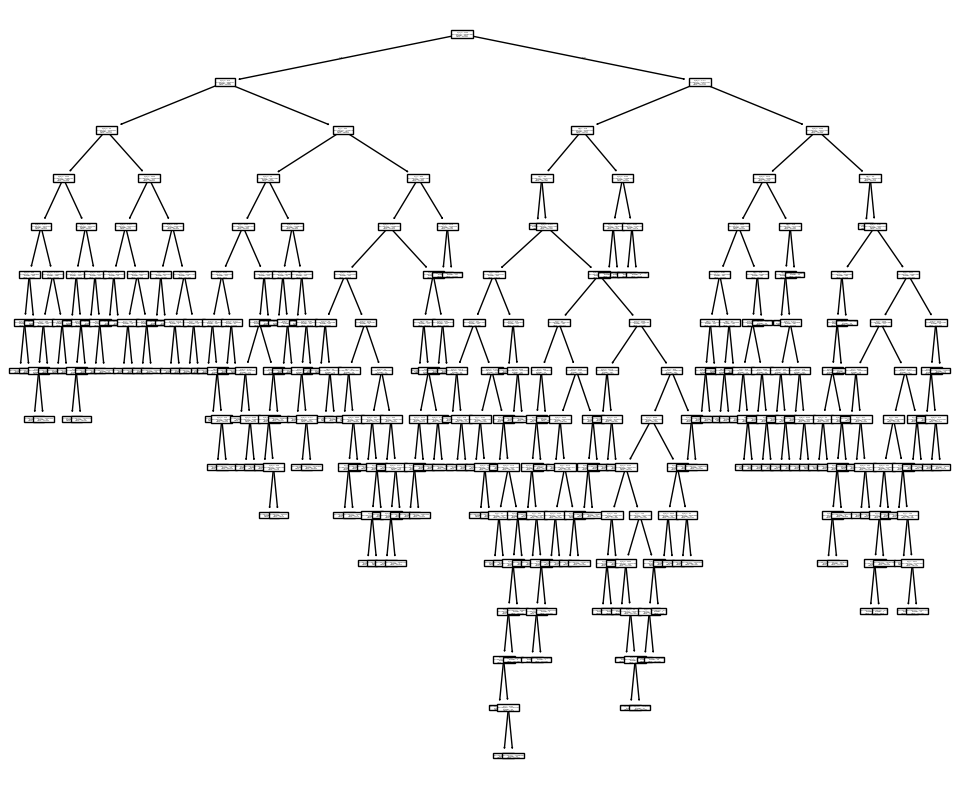

In [66]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_tree(post_prun_dt);

Feature importances

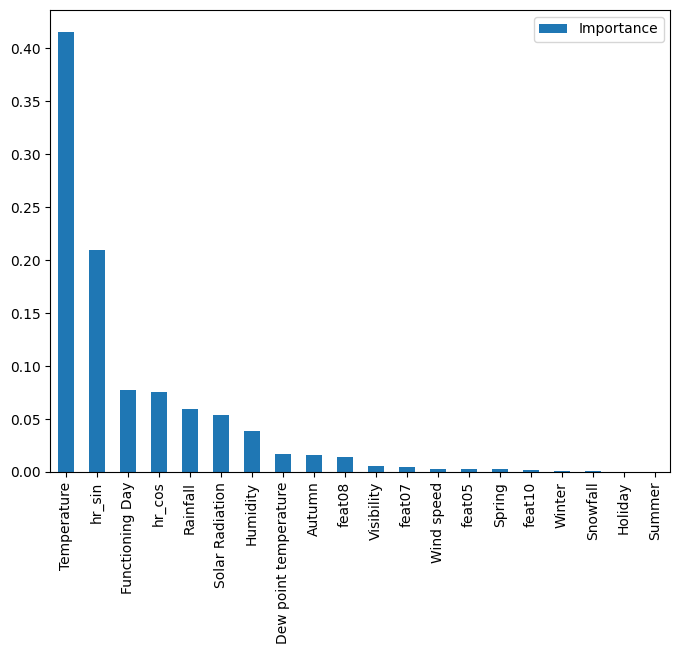

In [67]:
feat_importances = pd.DataFrame(post_prun_dt.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6));

## XGBoost

The second model we will consider is XGBoost. Here, we will again utilize grid search to find the best values of hyperparameters

In [68]:
# Define the parameter space for the xgboost grid search
xgb_param_space = {
    "objective": ["reg:squarederror"],
    "eta": [0.01, 0.1, 0.3, 0.5],
    "max_depth": np.arange(3, 12, 1),
    "colsample_bytree": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "min_child_weight": np.arange(50, 150, 20),
    "subsample": np.arange(0.4, 0.8, 0.1),
}

In [69]:
# Initialize the grid search model
grid_cv = GridSearchCV(xgb.XGBRegressor(), xgb_param_space, cv=5, n_jobs=-1, verbose=1)

In [70]:
# Fit the model
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5040 candidates, totalling 25200 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                              0.8],
                         'eta': [0.01, 0.1, 0.3, 0.5],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'min_child_weight': array([ 50,  70,  90, 110, 130]),
                         'objective': ['reg:squarederror'],
                         'subsample': array([0.4, 0.5, 0.6, 0.7])},
             verbose=1)

##### Best model found using grid search

In [71]:
# Best model parameters
grid_cv.best_params_

{'colsample_bytree': 0.8,
 'eta': 0.1,
 'max_depth': np.int64(10),
 'min_child_weight': np.int64(50),
 'objective': 'reg:squarederror',
 'subsample': np.float64(0.7)}

In [72]:
# Best model
xgb_reg = grid_cv.best_estimator_

##### Visualizations

Feature importances

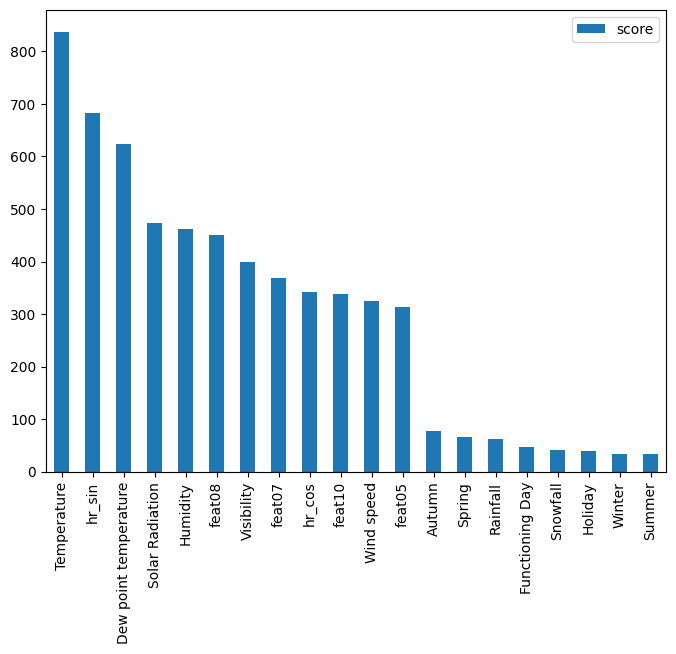

In [73]:
feature_important = xgb_reg.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
feature_importance.plot(kind='bar', figsize = (8,6)); ## plot top 40 features

Tree

<Figure size 1500x1000 with 0 Axes>

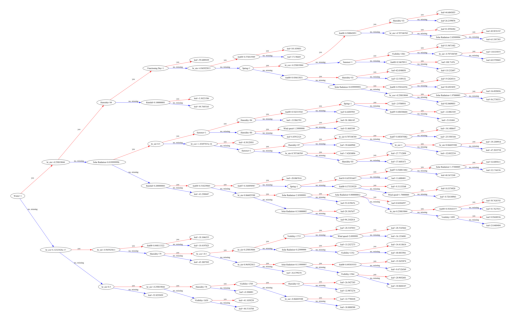

In [74]:
plt.figure(figsize=(15, 10))
plot_tree_xgb(xgb_reg, num_trees=0, rankdir='LR');

##### Calculating the scores

In [75]:
xgb_preds_train = xgb_reg.predict(X_train)
xgb_score_train = get_performance_metrics(y_train, xgb_preds_train)
xgb_score_train

{'MSE': 21314.15, 'RMSE': 145.99, 'R2': 0.94, 'MAE': 93.09}

In [76]:
xgb_preds = xgb_reg.predict(X_test)
xgb_score = get_performance_metrics(y_test, xgb_preds)
xgb_score

{'MSE': 37554.13, 'RMSE': 193.79, 'R2': 0.89, 'MAE': 120.15}

## Neural Network

For the last model we will utilize Neural Network

In [77]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [78]:
X_train_tensor.shape, y_train_tensor.shape

(TensorShape([9344, 20]), TensorShape([9344]))

##### Create the NN and build initial model

In [79]:
def get_nn_model():
    inputs = layers.Input(shape=(X_train_tensor.shape[1],), dtype=tf.float32, name="input_layer")
    x = layers.BatchNormalization(name="normalization_layer")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_layer_0")(x)
    x = layers.Dense(64, activation="relu", name="dense_layer_1")(x)
    x = layers.Dense(64, activation="relu", name="dense_layer_2")(x)
    x = layers.Dense(64, activation="relu", name="dense_layer_3")(x)
    x = layers.Dense(64, activation="relu", name="dense_layer_4")(x)
    outputs = layers.Dense(1, activation="linear", name="output_layer")(x)

    model = tf.keras.Model(inputs, outputs)

    # Compile
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mae"])
    model.name = "nn_model"
    return model

In [80]:
initial_model = get_nn_model()
initial_model.summary()

Model: "nn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_layer             │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_0 (Dense)           │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_3 (Dense)           │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_4 (Dense)           │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,129 (70.82 KB)

 Trainable params: 18,089 (70.66 KB)

 Non-trainable params: 40 (160.00 B)

In [81]:
initial_model_history = initial_model.fit(X_train_tensor, y_train_tensor, epochs=100, verbose=2)

Epoch 1/100
292/292 - 1s - 3ms/step - loss: 245386.9844 - mae: 320.1716
Epoch 2/100
292/292 - 0s - 554us/step - loss: 119795.9844 - mae: 226.6722
Epoch 3/100
292/292 - 0s - 559us/step - loss: 103007.7109 - mae: 211.4456
Epoch 4/100
292/292 - 0s - 552us/step - loss: 93418.1484 - mae: 200.0350
Epoch 5/100
292/292 - 0s - 555us/step - loss: 84730.6328 - mae: 189.4541
Epoch 6/100
292/292 - 0s - 548us/step - loss: 81753.9922 - mae: 185.1457
Epoch 7/100
292/292 - 0s - 554us/step - loss: 76690.6094 - mae: 178.1075
Epoch 8/100
292/292 - 0s - 564us/step - loss: 76479.8047 - mae: 179.6996
Epoch 9/100
292/292 - 0s - 562us/step - loss: 69749.8750 - mae: 170.3661
Epoch 10/100
292/292 - 0s - 568us/step - loss: 70347.5234 - mae: 170.6807
Epoch 11/100
292/292 - 0s - 586us/step - loss: 68745.1719 - mae: 168.7278
Epoch 12/100
292/292 - 0s - 580us/step - loss: 67095.7109 - mae: 166.8006
Epoch 13/100
292/292 - 0s - 583us/step - loss: 67471.9688 - mae: 166.2263
Epoch 14/100
292/292 - 0s - 568us/step - loss:

##### Cross-validation

In [82]:
k = 5
kf = KFold(n_splits=k)
kfold_results = []
for i, (train_idxs, test_idxs) in enumerate(kf.split(X_train, y_train)):
    print(f"Fitting Kfold no. {i+1}/{k}")
    x_train_tensor = tf.convert_to_tensor(X_train.iloc[train_idxs, ], dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train.iloc[train_idxs, ], dtype=tf.float32)
    x_test_tensor = tf.convert_to_tensor(X_train.iloc[test_idxs, ], dtype=tf.float32)
    y_test_tensor = tf.convert_to_tensor(y_train.iloc[test_idxs, ], dtype=tf.float32)
    model = get_nn_model()
    model_history = model.fit(x_train_tensor, y_train_tensor, validation_data=(x_test_tensor, y_test_tensor), epochs=100, verbose=0, batch_size=64)
    kfold_results.append(model_history)

Fitting Kfold no. 1/5
Fitting Kfold no. 2/5
Fitting Kfold no. 3/5
Fitting Kfold no. 4/5
Fitting Kfold no. 5/5


##### MAE plots for all folds

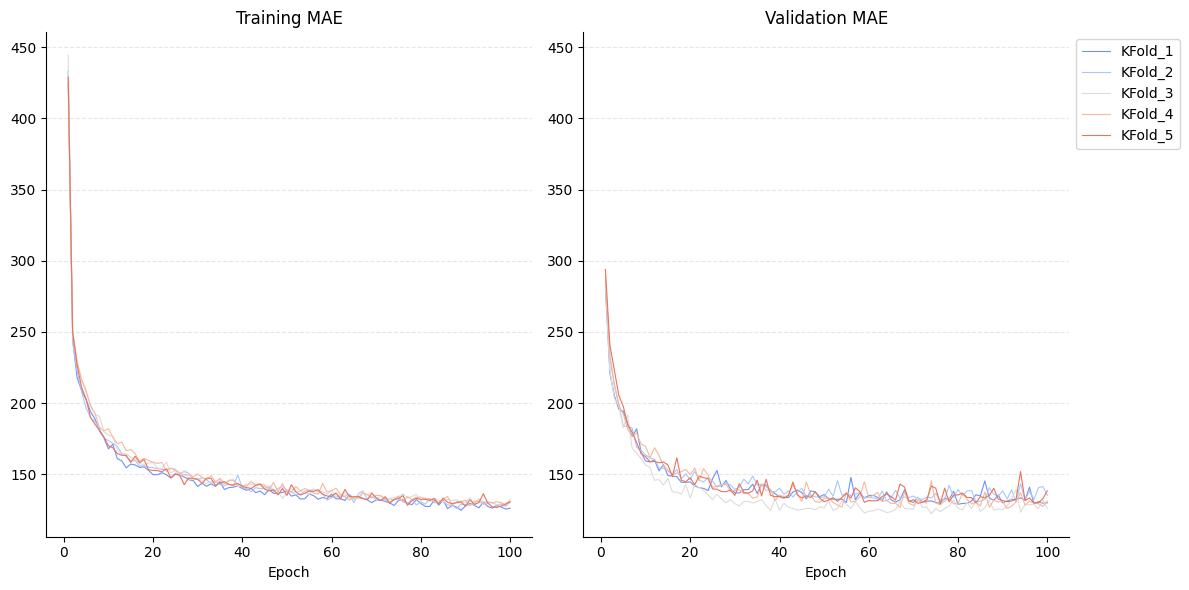

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
colors = sns.color_palette("coolwarm", 5)

for i, history_obj in enumerate(kfold_results):
    sns.lineplot(x=range(1,101), y=history_obj.history["mae"], ax=axes[0], label=f"KFold_{i+1}", color=colors[i], lw=.8, legend=False)
    sns.lineplot(x=range(1,101), y=history_obj.history["val_mae"], ax=axes[1], lw=.8, label=f"KFold_{i+1}", color=colors[i])
axes[0].set_title("Training MAE")
axes[0].set_xlabel("Epoch")
axes[0].yaxis.grid(True, linestyle="--", alpha=0.3)
axes[1].set_title("Validation MAE")
axes[1].set_xlabel("Epoch")
axes[1].legend(loc="upper left", bbox_to_anchor=(1, 1))
axes[1].yaxis.grid(True, linestyle="--", alpha=0.3)
axes[1].yaxis.set_tick_params(labelleft=True)
sns.despine()
plt.tight_layout()
plt.show()

In [84]:
kfold_averages = {
    "mae": [sum(values)/len(values) for values in zip(*[item.history["mae"] for item in kfold_results])],
    "val_mae": [sum(values)/len(values) for values in zip(*[item.history["val_mae"] for item in kfold_results])]
}

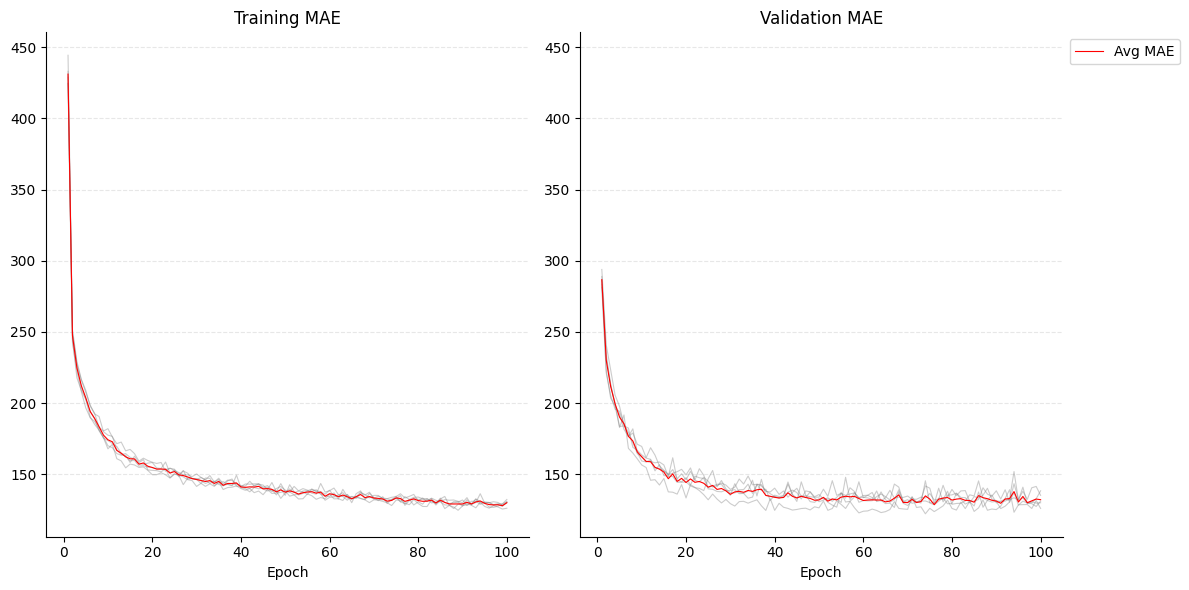

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
colors = sns.color_palette("coolwarm", 5)

for i, history_obj in enumerate(kfold_results):
    sns.lineplot(x=range(1,101), y=history_obj.history["mae"], ax=axes[0], color="#808080", legend=False, lw=.8, alpha=.4)
    sns.lineplot(x=range(1,101), y=history_obj.history["val_mae"], ax=axes[1], lw=.8, color="#808080", alpha=.4)
sns.lineplot(x=range(1,101), y=kfold_averages["mae"], label=f"Avg MAE", ax=axes[0], lw=.8, legend=False, color="red")
sns.lineplot(x=range(1,101), y=kfold_averages["val_mae"], label=f"Avg MAE", ax=axes[1], lw=.8, color="red")
axes[0].set_title("Training MAE")
axes[0].set_xlabel("Epoch")
axes[0].yaxis.grid(True, linestyle="--", alpha=0.3)
axes[1].set_title("Validation MAE")
axes[1].set_xlabel("Epoch")
axes[1].yaxis.grid(True, linestyle="--", alpha=0.3)
axes[1].legend(loc="upper left", bbox_to_anchor=(1, 1))
axes[1].yaxis.set_tick_params(labelleft=True)
sns.despine()
plt.tight_layout()
plt.show()


Based on the cross validation results, we may be dealing with some overfitting after the epoch 80, as the MAE for training keeps decreasing, while validation MAE stays around the same level. Thus we will train the final model for 80 epochs

In [86]:
nn_model = get_nn_model()
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

nn_model_history = nn_model.fit(X_train_tensor, y_train_tensor, epochs=80, verbose=2, batch_size=64)

Epoch 1/80
146/146 - 1s - 5ms/step - loss: 349481.4375 - mae: 391.0264
Epoch 2/80
146/146 - 0s - 629us/step - loss: 122638.8047 - mae: 233.1290
Epoch 3/80
146/146 - 0s - 612us/step - loss: 104368.6719 - mae: 210.9947
Epoch 4/80
146/146 - 0s - 612us/step - loss: 93021.9219 - mae: 200.0331
Epoch 5/80
146/146 - 0s - 607us/step - loss: 88250.3750 - mae: 195.0293
Epoch 6/80
146/146 - 0s - 605us/step - loss: 78278.0312 - mae: 184.5668
Epoch 7/80
146/146 - 0s - 614us/step - loss: 75184.1641 - mae: 178.5454
Epoch 8/80
146/146 - 0s - 606us/step - loss: 72037.9141 - mae: 173.3196
Epoch 9/80
146/146 - 0s - 610us/step - loss: 68934.4688 - mae: 169.8327
Epoch 10/80
146/146 - 0s - 612us/step - loss: 65765.8047 - mae: 164.8508
Epoch 11/80
146/146 - 0s - 604us/step - loss: 62520.4531 - mae: 160.4493
Epoch 12/80
146/146 - 0s - 607us/step - loss: 61703.3086 - mae: 158.3585
Epoch 13/80
146/146 - 0s - 604us/step - loss: 63168.9805 - mae: 160.5483
Epoch 14/80
146/146 - 0s - 607us/step - loss: 58525.4258 - 

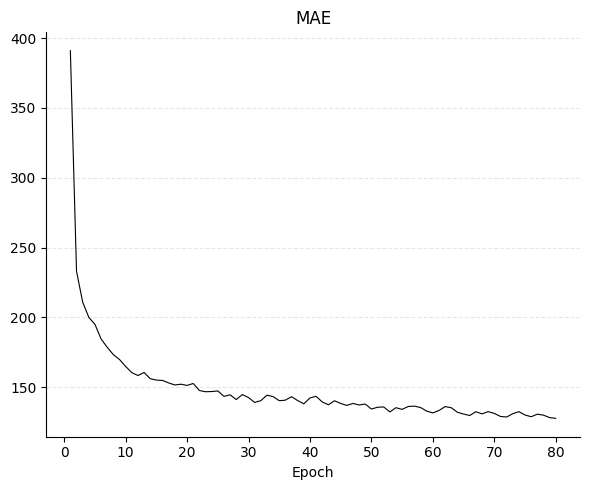

In [87]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.lineplot(x=range(1,81), y=nn_model_history.history["mae"], label=f"MAE", lw=.8, legend=False, color="black")
ax.set_title("MAE")
ax.set_xlabel("Epoch")
ax.yaxis.grid(True, linestyle="--", alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


##### Calculating the scores

In [88]:
nn_preds_train = nn_model.predict(X_train_tensor)
nn_score_train = get_performance_metrics(y_train, nn_preds_train)
nn_score_train

292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


{'MSE': 30188.32, 'RMSE': 173.75, 'R2': 0.92, 'MAE': 108.5}

In [89]:
nn_preds = nn_model.predict(X_test_tensor)
nn_score = get_performance_metrics(y_test, nn_preds)
nn_score

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


{'MSE': 37382.71, 'RMSE': 193.35, 'R2': 0.89, 'MAE': 119.91}

# Results

In [90]:
results_df = pd.DataFrame(
    [
        {"Model": "Decision_Tree_Pre", "test": False, **pre_prun_score_train},
        {"Model": "Decision_Tree_Pre", "test": True, **pre_prun_score},
        {"Model": "Decision_Tree_Post", "test": False, **post_prun_score_train},
        {"Model": "Decision_Tree_Post", "test": True, **post_prun_score},
        {"Model": "XGBoost", "test": False, **xgb_score_train},
        {"Model": "XGBoost", "test": True, **xgb_score},
        {"Model": "Neural_Network", "test": False, **nn_score_train},
        {"Model": "Neural_Network", "test": True, **nn_score}
    ]
)

##### Plotting the scores

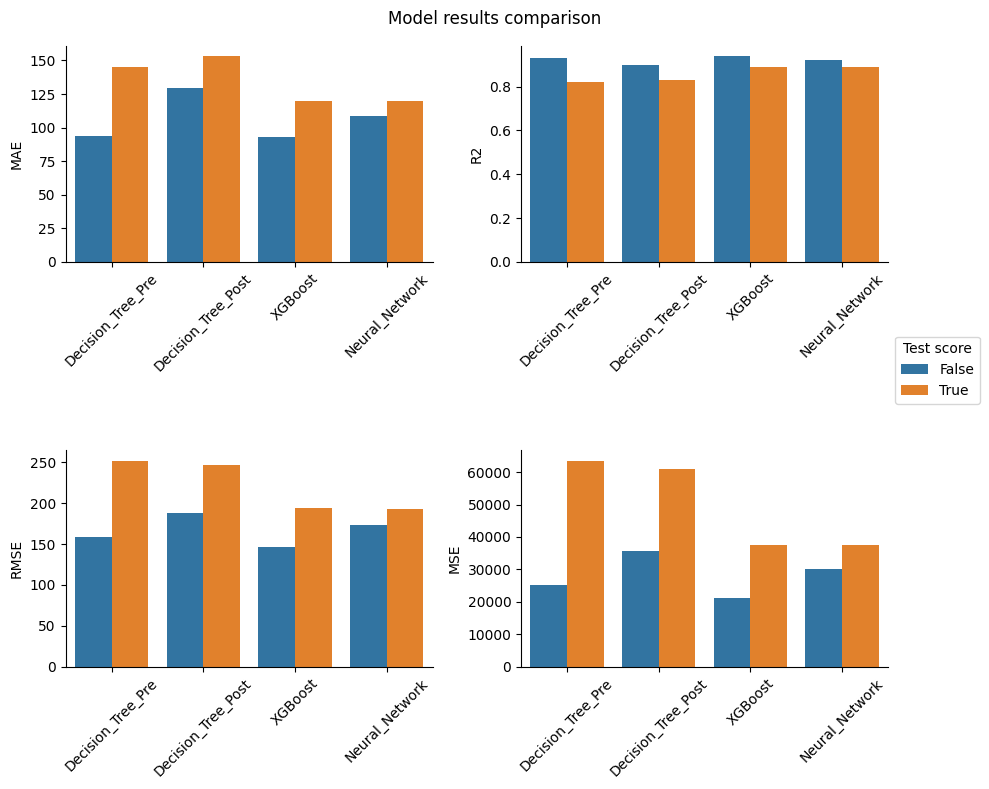

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
sns.barplot(data=results_df, x="Model", y="MAE", hue="test", ax=axes[0], legend=False)
sns.barplot(data=results_df, x="Model", y="R2", hue="test", ax=axes[1])
sns.barplot(data=results_df, x="Model", y="RMSE", hue="test", ax=axes[2], legend=False)
sns.barplot(data=results_df, x="Model", y="MSE", hue="test", ax=axes[3], legend=False)
for ax in axes:
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, loc='center left', bbox_to_anchor=(1, -0.5), title='Test score')
plt.suptitle("Model results comparison")
sns.despine()
plt.tight_layout()
plt.show()

# Conclusions

As we can see, the Decision Tree models have performed the worst, also exibiting high levels of overfitting. XGBoost and Neural Network seems to have performed the best.

The XGBoost model seems to have scored better on the both train and test scores compared to the Neural Network, however, it seems to be more overfitted as the differences betweent train and test scores are visibly higher

In [92]:
print("Train Results")
results_df.loc[(results_df["Model"].isin(["XGBoost", "Neural_Network"]) & ~results_df["test"]),["Model", "MSE", "RMSE", "R2", "MAE"]]

Train Results


Model       MSE    RMSE    R2     MAE
4         XGBoost  21314.15  145.99  0.94   93.09
6  Neural_Network  30188.32  173.75  0.92  108.50

In [93]:
print("Test Results")
results_df.loc[(results_df["Model"].isin(["XGBoost", "Neural_Network"]) & results_df["test"]),["Model", "MSE", "RMSE", "R2", "MAE"]]

Test Results


Model       MSE    RMSE    R2     MAE
5         XGBoost  37554.13  193.79  0.89  120.15
7  Neural_Network  37382.71  193.35  0.89  119.91

Closer inspection of the data confirms this. XGBoost test results are better, with model being more overfitted than the Neural Network. However, the differences in test scores for both models are minimal. 

Based on above informations, we will prefer to select the **Neural Network** as the best obtained model as in our opinion the overfitting problem of XGBoost model outweigths the slightly better test scores.